# Ohio 2022 PBER

From Geoff: “What I would like by June 20th is a csv that assigns each 2020 Census block to a 2022 precinct from the Ohio SoS's general election results file.”

To Geoff: “…We've decided to start processing the shapefiles now so that there'll be minimal lag time between collection and release of the file. Although I don't anticipate this, in a worst case scenario, we'd be happy to share with you whatever intermediate file we have by June 20th.”

## Fine to use 2020 data vs Need digitization tracking

- * indicates adopted pre-2020 and therefore no updates needed
- P indicates the collection team only found PDF maps, no geospatial data

* ashtabula - used for 10 years except for single parcel change 1/24/23 in Orwell TWP/Orwell Vill
* P adams - not changed for 2022, not sure when first adopted
(P allen - map dated 9-28-21)
* athens - adopted in 2011
* P auglaize - date stamped 9/26/06
* belmont - adopted 2012/updated 2019
brown - adopted 5-21
butler - adopted 2-22
* P carrol - adopted 2019 or earlier
* P champaign - adopted 5-18
* P clinton - no change for 2022, not sure when first adopted
clark - adopted early 2022
clermont - adopted early 2022
columbiana - adopted 11-21
* P coshockton - no change for 2022, not sure when first adopted
* P crawford - no change for 2022, not sure when first adopted
cuyahoga - not sure when adopted
* P darke - no change for 2022, not sure when first adopted
* P defiance - first adopted 2018
delaware - adopted 2-2022
erie - adopted 1-2021
* fairfield - first adopted 2019
* fayette - adopted 2019 or earlier
* franklin - first adopted 8-2019
* fulton - first adopted 1-2019
* P gallia - no change for 2022, not sure when first adopted
geauga - first adopted 9-2021
* P greene - first adopted 2015, used 2020
* P guernsey - adopted 2005
hamilton - adopted early 2022
* hancock - adopted 2-2020, same map as 2020
hardin - no change for 2022, not sure when first adopted
* P harrison - wip, first adopted 2010
* henry - first adopted 1-2019
* highland - first adotped 2018 - cant be used but do match 2020 seems
hocking - first adopted 2021/2022
* holmes - first adopted 1/1/14
(P huron - first adoped 3/17 or 2021, based on map date stamp vs BOE director)
* P jackson - "many years ago"
* jefferson - adopted 2012
* knox - adopted 11/2019
* lawrence - precinct havent changed in 20 years, they claim
lake - first adopted 2021
* licking - first adopted 2015
* logan - "Used the 2018 map for all three 2022 elections"
* lorain - adopted after 2022 general election (so ...2022 general and prim used 2020 precs?)
* lucas - adopted 2019
(P madison - adopted 2022 (before or after elections?))
* mahoning - adopted 2012
* marion - adopted august 2015 used for primary elections, august 2022 map used for gen elec
medina - no info in metadata on previous use
* meigs - no change for 2022 - think this means same as 2020
mercer - new for 2022
miami - new for 2022
* monroe - adopted pre-2018
* P morgan - adopted pre-2019
* morrow - adopted 2017 or earlier
montgomery - adopted march 2022, used in primaries too
muskingum - adopted 2022
* noble - no 2022 changes, think this means same as 2020
* ottawa - adopted December 2022, so I think 2020 map likely used for actual elections?
* paulding - adopted pre 2020
* perry - adopted 2013
pickaway - adopted early 2022
* P pike - adopted 2002
portage - adopted 2022 for general, 2017 for primary
* P preble - no 2022 changes, so I think 2020 map works
* putnam - no 2022 changes, stamped 2019 - given other spots that say "before 2020" not sure
* richland - adopted 2018 or earlier
* ross - adopted 2013
* P sandusky - adopted 2009
* P scioto - adopted before 2020
* shelby - adopted before 2020
stark - adopted 2022
* summit - adopted 2013, a change in 2017 (and dec 2022?)
tuscarawas - adopted between 2020 and 2022
* union - adopted 2019
* P vanwert - adopted pre-2020
* P vinton - adopted pre-2020
* warren - adopted pre-2020
* washington - adopted 2016 or earlier
* wayne - adopted 2015, some updates since (not nec any one shp ever used??)
* williams - adopted pre-2019
wood - adopted early 2022
* P wyandot - adopted 2019 - one 2022 update due to cong split (?)

## Imports libraries and 2022 Election Results

In [1]:
import os
import numpy as np 
import geopandas as gp
import pandas as pd
from op_verification import reference_data
import time
import warnings
warnings.filterwarnings('ignore')


#2022 precinct election results, no geospatial data
er22 = pd.read_csv('./raw-from-source/oh_2022_gen_prec/oh_2022_gen_prec.csv')
#New precinct boundaries since 2020 --> new precinct name matching required. "madison", "huron","allen" initially in list but removed after confirming 2022 pdf map with 2020 geospatial data
prec_counties_new22_set = {"brown","butler","clark","clermont","columbiana","cuyahoga","delaware", "erie","geauga","hamilton","hardin", 
                           "hocking","lake","lucas","lorain","marion","medina","mercer","miami","montgomery","muskingum","pickaway","portage",
                           "stark","tuscarawas","wood"}

## Compare 2020 boundary precincts to 2022 election result precincts
Note "ZZZ"/"VOTING DISTRICTS NOT DEFINED" refers to water areas with no precinct but should be included in the map#Note "ZZZ"/"VOTING DISTRICTS NOT DEFINED" refers to water areas with no precinct but should be included in the map

In [2]:
#2020 precinct boundaries and election results file filtered for only boundaries -- 2022 boundaries below in "Precinct name matching 2022 section"
bound20rdh = gp.read_file("./raw-from-source/oh_gen_20_prec/oh_gen_20_st_prec.shp")[['UNIQUE_ID', "STATEFP20","COUNTYFP20", "PRECINCT20","NAME20","geometry"]]
#Format county/county name columns to maptch ER22 for comparison
bound20rdh['COUNTY'] = ("39"+bound20rdh['COUNTYFP20']).map(reference_data.geoid_to_county_name)
bound20rdh['COUNTYNM'] = bound20rdh['COUNTY'].str.lower().str.slice(stop=-7)
county_name_to_fips_dict = pd.Series(bound20rdh['COUNTYFP20'].values, index=bound20rdh['COUNTYNM']).to_dict()
print("Compare all precinct data between 2020 and 2022:")
#Confirm county names match up
assert set(bound20rdh['COUNTYNM'])-set(er22["County"].str.lower()) == set()
assert set(er22["County"].str.lower())-set(bound20rdh['COUNTYNM']) == set()
#Considering 2020/2022 comparison some more
print("2022 ER unique_id nunique: ",er22["UNIQUE_ID"].nunique() ,"\nshape: ", er22["UNIQUE_ID"].shape, "\nprec name nunique: ", er22["PRECNAME"].nunique(), "\nprec name w county nunique",(er22["PRECCODE"]+er22["County"]).nunique())
print("2020 PB NAME20 nunique: ",bound20rdh["NAME20"].nunique(),"\nshape:",bound20rdh.shape, "\nprec name nunique: ",bound20rdh["PRECINCT20"].nunique(),"\nprec name w county nunique",(bound20rdh["PRECINCT20"]+bound20rdh["COUNTYNM"]).nunique())

print("\nCompare subset of counties that we expect to match between 2020 and 2022:")
#set of counties with reused precinct boundaries from pre-2020, therefore can use 2020 geospatial data
counties_reused22_set = set(er22["County"].str.lower())-prec_counties_new22_set
#2022 ER df subset counties where geospatial data can be reused
er22_reused_counties_df = er22[er22["County"].str.lower().isin(counties_reused22_set)]
#2020 Bound gdf subset counties where geospatial data can be reused
bound20_reused_counties_gdf = bound20rdh[(bound20rdh["COUNTYNM"].isin(counties_reused22_set))|(bound20rdh["PRECINCT20"]=="ZZZ")]
#Check if Precincts line up/what mismatches - as expected, only for ZZZ 0 voter precicnts
print("prec w/county diff: pb comp er len: ", len(set(bound20_reused_counties_gdf["PRECINCT20"]+bound20_reused_counties_gdf["COUNTYNM"].str.lower())-set(er22_reused_counties_df["PRECCODE"]+er22_reused_counties_df["County"].str.lower())))
print("prec w/county diff: er comp pb len: ", len(set(er22_reused_counties_df["PRECCODE"]+er22_reused_counties_df["County"].str.lower())-set(bound20_reused_counties_gdf["PRECINCT20"]+bound20_reused_counties_gdf["COUNTYNM"])))
print("prec county diff: er comp pb names: ", set(er22_reused_counties_df["PRECCODE"]+er22_reused_counties_df["County"].str.lower())-set(bound20_reused_counties_gdf["PRECINCT20"]+bound20_reused_counties_gdf["COUNTYNM"]))
print("prec county diff: pb comp er names: ", set(bound20_reused_counties_gdf["PRECINCT20"]+bound20_reused_counties_gdf["COUNTYNM"].str.lower())-set(er22_reused_counties_df["PRECCODE"]+er22_reused_counties_df["County"].str.lower()))

#Create common column to join on
er22_reused_counties_df["UNIQUE_ID_code"] = er22_reused_counties_df["County"].str.upper() + "-"+er22_reused_counties_df["PRECCODE"]
bound20_reused_counties_gdf["UNIQUE_ID_code"] = bound20_reused_counties_gdf["COUNTYNM"].str.upper()+"-"+bound20_reused_counties_gdf["PRECINCT20"]
#Join 2020 bounds with 2022 ER where appropriate
pber_prec_reused_gdf = pd.merge(er22_reused_counties_df, bound20_reused_counties_gdf, on = "UNIQUE_ID_code", how = "outer", indicator=True)
print("\nCompare post-merge:")
print("shape merged gdf: ",pber_prec_reused_gdf.shape, "\nunmatched shape: ",pber_prec_reused_gdf[pber_prec_reused_gdf["_merge"]!="both"].shape)
print("county from er not matching: ",pber_prec_reused_gdf["County"][pber_prec_reused_gdf["_merge"]!="both"].unique())
print("county from bound not matching, not zzz: ",pber_prec_reused_gdf["COUNTYNM"][(pber_prec_reused_gdf["_merge"]!="both")&(pber_prec_reused_gdf["PRECINCT20"]!="ZZZ")].unique())

Compare all precinct data between 2020 and 2022:
2022 ER unique_id nunique:  8933 
shape:  (8933,) 
prec name nunique:  8760 
prec name w county nunique 8933
2020 PB NAME20 nunique:  8673 
shape: (8941, 8) 
prec name nunique:  1550 
prec name w county nunique 8941

Compare subset of counties that we expect to match between 2020 and 2022:
prec w/county diff: pb comp er len:  8
prec w/county diff: er comp pb len:  0
prec county diff: er comp pb names:  set()
prec county diff: pb comp er names:  {'ZZZlake', 'ZZZashtabula', 'ZZZottawa', 'ZZZportage', 'ZZZlucas', 'ZZZerie', 'ZZZlorain', 'ZZZcuyahoga'}

Compare post-merge:
shape merged gdf:  (4375, 269) 
unmatched shape:  (8, 269)
county from er not matching:  [nan]
county from bound not matching, not zzz:  []


## Precinct name matching 2022

**Full Match:** 
- precinct names match 2022 ER, precinct names are unique identifiers within the county

**Too many polygons:** 
- precinct names match 2022 ER, precinct names are unique within county in ER, NOT in PB - no identifier to differentiate in PB other than geometry col
    - Solution: dissolve by precinct name which matches with ER

**Questions addressed along the way:** 
- More polygons with unique precinct names in 2022 Precinct Boundary (PB) file than in 2022 Election Results (ER) File
    - Impacts: Butler, Cuyahoga
    - Solution: In cases where a precinct is split, merge together to match the ER (dissolve)
        - Example: In Butler County the Precinct Boundaries contain ( 'TRENTON1.MAD','TRENTON1.TRE') whereas the election results just contain 'TRENTON1'
        - In this case MAD and TRE in TRENTON1 would get merged together..
- Number of unique precinct names in boundary file does not match # polygons OR # unique precinct names in ER file
    - Impacts: Pickaway
    - Explanation: Boundary file has 77 rows, 35 unique precinct names, election results file has 43 unique precinct names
    - Solution: combine two separate shapefiles and use name matching spreadsheet provided by OE and BOE
- A few names with no match
    - Impacts: Erie 
    - Explanation: Erie (what to do with "Bellevue City-Annexed-Refer to Board of Elections" from boundary file? -- )
    - Solution: 
- No names match
    - Impacts: Wood
    - Explanation: After reading in all of the precinct shapes that the county provided separately, the precinct identifier is a number in the boundary file that does not match any of the identifiers in the election results
    - Solution: precinct name matching spreadsheet from OpenElections/BOE
    
- All names match, but null names in PB cause holes in plot
    - Impacts: Portage
    - Explanation: There are 129 precinct names in the ER. There are 129 names in PB that match ER. 
    - Solution: Merge with other part of precinct/name and dissolve for Ravenna, Arsenal, Tallmadge

In [3]:
def check_precid_uniqueness(county_gdf_list, ):
    '''
    Checks that the "prec_id" column created for each county gdf is unique within the county and that it matches the precinct identifiers in the election results df. 
    If it is not unique or does not match, function will return and assertion error
    Parameter county_df_list: list of dataframes where each dataframe is one county to be considered 
    '''
    print("number of counties in list: ",len(county_gdf_list))
    for county in county_gdf_list:
        print("check prec_id for: ", county["county"][0])
        assert county["prec_id"].nunique()==len(county)
        assert set(county["prec_id"])-set(er22["PRECNAME"][er22["County"].str.upper()==county["county"][0]])==set(er22["PRECNAME"][er22["County"].str.upper()==county["county"][0]])-set(county["prec_id"])==set()
    
    return "all counties pass check"


print("Number of counties new to 2022//need precinct name matching: ",len(prec_counties_new22_set))

Number of counties new to 2022//need precinct name matching:  26


### Full Match

In [4]:
#Clark: Full match
clark = gp.read_file("./raw-from-source/boundaries/clark_precincts_2023/ClarkCountyPrecinctData.shp")
clark['prec_id'] = "PRECINCT "+clark['NAME']
clark.loc[clark['NAME'].str.contains("BETHEL"), "prec_id"] = clark['prec_id'].str.replace("BETHEL", "BETH")
clark.loc[clark['NAME'].str.contains(" 0"), "prec_id"] = clark['prec_id'].str.replace(" 0", " ")
clark.loc[clark['NAME'].str.contains("MR "), "prec_id"] = clark['prec_id'].str.replace("MR ", "MR-")
clark.loc[clark['NAME'].str.contains("HARMONY"), "prec_id"] = clark['prec_id'].str.replace("HARMONY", "HARM")
clark.loc[clark['NAME'].str.contains("T-0"), "prec_id"] = clark['prec_id'].str.replace("T-0", "T-")
clark.loc[clark['NAME'].str.contains("GERMAN"), "prec_id"] = clark['prec_id'].str.replace("GERMAN", "GERM")
clark.loc[clark['NAME'].str.contains("GREEN"), "prec_id"] = clark['prec_id'].str.replace("GREEN", "GREE")
clark['county'] = 'CLARK'
clark['UNIQUE_ID'] = clark['county']+"-"+clark["prec_id"]
clark = clark.to_crs(bound20_reused_counties_gdf.crs)


#Columbiana: Full match
columbiana = gp.read_file("./raw-from-source/boundaries/columbiana_precincts_2022/Voting_Precincts_2022.shp")
columbiana_dict = {"HANOVER TWP NW":'PRECINCT HANOVER TWP NORTH',"WELLSVILLE 2":'PRECINCT WELLSVILLE  2',"PERRY SW":'PRECINCT PERRY TWP SW',
                   "PERRY NORTH":'PRECINCT PERRY TWP NORTH',"LEETONIA":'PRECINCT LEETONIA VIL', "NEGLEY":'PRECINCT MIDDLETON TWP NEGLEY',
                   "ROGERS":'PRECINCT MIDDLETON TWP ROGERS',"ST CLAIR SOUTH":'PRECINCT ST CLAIR TWP SOUTH',
                   "WEST TWP E ROCHESTER":'PRECINCT WEST TWP EAST ROCHESTER',"WELLSVILLE 1":'PRECINCT WELLSVILLE  1'}
columbiana["prec_id"] = "PRECINCT "+columbiana["PRECNAME"].str.upper().str.replace("TOWNSHIP", "TWP")
columbiana.loc[columbiana["PRECNAME"].isin(columbiana_dict.keys()), "prec_id"] = columbiana["PRECNAME"].map(columbiana_dict)
columbiana["county"] = "COLUMBIANA"
columbiana["UNIQUE_ID"] = columbiana["county"]+"-"+columbiana["prec_id"]
columbiana = columbiana.to_crs(bound20_reused_counties_gdf.crs)


#Delaware: Full match
delaware = gp.read_file("./raw-from-source/boundaries/delaware_precincts_2022/Precinct.shp")
delaware['prec_id'] = "PRECINCT " + delaware['PREC_NAME'].str.upper()
delaware["county"] = "DELAWARE"
delaware.loc[delaware["PREC_NAME"].str.contains("COLUMBUS"), "prec_id"] = "PRECINCT "+delaware["PREC_NAME"].str.replace("COLUMBUS ", "COLUMBUS CITY ")
delaware.loc[delaware["PREC_NAME"].str.contains("DUBLIN"), "prec_id"] = "PRECINCT "+delaware["PREC_NAME"].str.replace("DUBLIN ", "DUBLIN CITY ")
delaware.loc[delaware["PREC_NAME"].str.contains("POWELL"), "prec_id"] = "PRECINCT "+delaware["PREC_NAME"].str.replace("POWELL ", "POWELL CITY ")
delaware.loc[delaware["PREC_NAME"].str.contains("SUNBURY"), "prec_id"] = "PRECINCT "+delaware["PREC_NAME"].str.replace("SUNBURY ", "SUNBURY CITY ")
delaware.loc[delaware["PREC_NAME"].str.contains("WESTERVILLE"), "prec_id"] = "PRECINCT "+delaware["PREC_NAME"].str.replace("WESTERVILLE ", "WESTERVILLE CITY ")
delaware["UNIQUE_ID"] = delaware["county"]+"-"+delaware["prec_id"]
delaware = delaware.to_crs(bound20_reused_counties_gdf.crs)


#Geauga: Full Match
geauga = gp.read_file("./raw-from-source/boundaries/geauga_precincts_2022/Precincts.shp")
geauga_prec_dict = {"B-76":"PRECINCT THOMPSON TWP B","B-51":"PRECINCT MONTVILLE TWP B", "C-42":"PRECINCT HAMBDEN TWP C", "A-23":"PRECINCT CHARDON TWP A","D-22":"PRECINCT CHARDON CITY D", "A-44":"PRECINCT HUNTSBURG TWP A", "B-38":"PRECINCT CLARIDON TWP B", "E-56":"PRECINCT MUNSON TWP E",
"D-30":"PRECINCT CHESTER TWP D","AQV-36":"PRECINCT AQUILLA VILLAGE", "B-49":"PRECINCT MIDDLEFIELD TWP B", "C-18":"PRECINCT BURTON TWP C", "A-58":"PRECINCT NEWBURY TWP A", "A-70":"PRECINCT RUSSELL TWP A", "HVV-69":"PRECINCT HUNTING VALLEY VILL", 
"B-47":"PRECINCT MIDDLEFIELD VILL B",
"BUR V-15":"PRECINCT BURTON VILLAGE", "B-64":"PRECINCT PARKMAN TWP B", "A-77":"PRECINCT TROY TWP A", "E-5":"PRECINCT AUBURN TWP E","F-11":"PRECINCT BAINBRIDGE TWP F", "A-75":"PRECINCT THOMPSON TWP A", "A-50":"PRECINCT MONTVILLE TWP A", "B-45":"PRECINCT HUNTSBURG TWP B", 
"A-46":"PRECINCT MIDDLEFIELD VILL A", "A-63":"PRECINCT PARKMAN TWP A", "B-78":"PRECINCT TROY TWP B", "A-16":"PRECINCT BURTON TWP A", "B-17":"PRECINCT BURTON TWP B", "A-37":"PRECINCT CLARIDON TWP A", "B-41":"PRECINCT HAMBDEN TWP B", "A-40":"PRECINCT HAMBDEN TWP A",
"D-43":"PRECINCT HAMBDEN TWP D", "C-25":"PRECINCT CHARDON TWP C","D-26":"PRECINCT CHARDON TWP D", "B-24":"PRECINCT CHARDON TWP B", "A-19":"PRECINCT CHARDON CITY A", "C-21":"PRECINCT CHARDON CITY C", "B-20":"PRECINCT CHARDON CITY B", "B-53":"PRECINCT MUNSON TWP B", 
"C-54":"PRECINCT MUNSON TWP C","F-57":"PRECINCT MUNSON TWP F", "B-59":"PRECINCT NEWBURY TWP B", "C-60":"PRECINCT NEWBURY TWP C", "E-62":"PRECINCT NEWBURY TWP E","D-61":"PRECINCT NEWBURY TWP D", "C-3":"PRECINCT AUBURN TWP C", "B-2":"PRECINCT AUBURN TWP B", 
"A-1":"PRECINCT AUBURN TWP A","D-4":"PRECINCT AUBURN TWP D", "A-6":"PRECINCT BAINBRIDGE TWP A", "C-8":"PRECINCT BAINBRIDGE TWP C", "E-10":"PRECINCT BAINBRIDGE TWP E","H-13":"PRECINCT BAINBRIDGE TWP H","I-14":"PRECINCT BAINBRIDGE TWP I","D-9":"PRECINCT BAINBRIDGE TWP D",
"D-68":"PRECINCT SOUTH RUSSELL VILL D", "B-66":"PRECINCT SOUTH RUSSELL VILL B", "A-65":"PRECINCT SOUTH RUSSELL VILL A", "C-67":"PRECINCT SOUTH RUSSELL VILL C", "E-74":"PRECINCT RUSSELL TWP E", "C-72":"PRECINCT RUSSELL TWP C", "B-71":"PRECINCT RUSSELL TWP B",
"D-73":"PRECINCT RUSSELL TWP D", "C-29":"PRECINCT CHESTER TWP C","G-33":"PRECINCT CHESTER TWP G","H-34":"PRECINCT CHESTER TWP H","I-35":"PRECINCT CHESTER TWP I", "A-27":"PRECINCT CHESTER TWP A", "B-28":"PRECINCT CHESTER TWP B", "E-31":"PRECINCT CHESTER TWP E",
"F-32":"PRECINCT CHESTER TWP F", "B-7":"PRECINCT BAINBRIDGE TWP B","G-12":"PRECINCT BAINBRIDGE TWP G","D-55":"PRECINCT MUNSON TWP D", "A-52":"PRECINCT MUNSON TWP A", "C-39":"PRECINCT CLARIDON TWP C", "A-48":"PRECINCT MIDDLEFIELD TWP A"}
geauga["prec_id"] = "na"
geauga.loc[geauga['PRECINCT2'].isin(geauga_prec_dict.keys()), "prec_id"] = geauga["PRECINCT2"].map(geauga_prec_dict)
geauga["county"] = "GEAUGA"
geauga["UNIQUE_ID"] = geauga["county"]+"-"+geauga["prec_id"]
geauga = geauga.to_crs(bound20_reused_counties_gdf.crs)


#Hamilton: Full Match
hamilton = gp.read_file("./raw-from-source/boundaries/hamilton_precincts_2022/PRECINT2021_0311.shp")
hamilton['prec_id'] = hamilton["PRC_NAME"]
hamilton['county'] = "HAMILTON"
hamilton["UNIQUE_ID"] = hamilton["county"]+"-"+hamilton["prec_id"]
hamilton = hamilton.to_crs(bound20_reused_counties_gdf.crs)


#Hardin: Full Match
hardin = gp.read_file("./raw-from-source/boundaries/hardin_precincts_2022/Hardin_Co_Precincts_2023-04.shp")
hardin["prec_id"] = hardin["precinct"].str.upper()
hardin["county"] = "HARDIN"
hardin["UNIQUE_ID"] = hardin["county"]+"-"+hardin["prec_id"]
hardin = hardin.to_crs(bound20_reused_counties_gdf.crs)


#Hocking: Full Match
hocking = gp.read_file("./raw-from-source/boundaries/hocking_precincts_2022/HOCKING_COUNTY_PRECINCTS_2022.shp")
hocking["prec_id"] = "PRECINCT " + hocking["PRECINCT"]
hocking.loc[hocking["PRECINCT"]=="SALT CREEK", "prec_id"] = "PRECINCT SALTCREEK"
hocking["county"] = "HOCKING"
hocking["UNIQUE_ID"] = hocking["county"]+"-"+hocking["prec_id"]
hocking = hocking.to_crs(bound20_reused_counties_gdf.crs)


#Lake: Full Match
lake = gp.read_file("./raw-from-source/boundaries/lake_precincts_2021/Lake_County_Voting_Precincts_(2021).shp")
lake["prec_id"] = lake["NAME"].str.upper()
lake.loc[~lake["NAME"].str.upper().str.contains("MENTOR-ON"), "prec_id"] = "PRECINCT "+lake["NAME"].str.upper()
lake.loc[lake["NAME"].str.upper().str.contains("MENTOR-ON"), "prec_id"] = lake["NAME"].str.upper().str.slice(stop=-2)+"CITY "+lake["NAME"].str.upper().str.slice(start=-2)
lake["county"] = "LAKE"
lake["UNIQUE_ID"] = lake["county"]+"-"+lake["prec_id"]
lake = lake.to_crs(bound20_reused_counties_gdf.crs)


#Marion: Full Match
marion_aug=gp.read_file("./raw-from-source/boundaries/marion_precincts_2022/MARION_COUNTY_PRECINCTS_CONSOLIDATED_AUG2022.shp")
marion_dec = gp.read_file("./raw-from-source/boundaries/marion_precincts_2022/City_Council_Wards_December2022.shp")
marion_dec["PRCT_NAME"] = "MARION " + marion_dec["WARD_ID"].astype(str)+"-"+marion_dec["Prect"]
marion = gp.GeoDataFrame(pd.concat([marion_aug, marion_dec], ignore_index=True), crs=bound20_reused_counties_gdf.crs)
marion["prec_id"] = "PRECINCT "+marion["PRCT_NAME"]
marion_dict = {'PRECINCT BIG ISLAND':'PRECINCT BIG ISLAND TWP','PRECINCT BOWLING GREEN':'PRECINCT BOWLING GREEN TWP',
               'PRECINCT CLARIDON A':'PRECINCT CLARIDON TWP A','PRECINCT CLARIDON B':'PRECINCT CLARIDON TWP B',
               'PRECINCT GRAND PRAIRIE':'PRECINCT GRAND PRAIRIE TWP','PRECINCT GRAND-SALT':'PRECINCT GRAND SALT',
               'PRECINCT GREEN CAMP':'PRECINCT GREEN CAMP TWP','PRECINCT MARION A':'PRECINCT MARION TWP A','PRECINCT MARION B':'PRECINCT MARION TWP B',
               'PRECINCT MARION C':'PRECINCT MARION TWP C','PRECINCT MARION D':'PRECINCT MARION TWP D','PRECINCT MARION E':'PRECINCT MARION TWP E',
               'PRECINCT MARION F':'PRECINCT MARION TWP F','PRECINCT MONTGOMERY':'PRECINCT MONTGOMERY TWP','PRECINCT PLEASANT A':'PRECINCT PLEASANT TWP A',
               'PRECINCT PLEASANT B':'PRECINCT PLEASANT TWP B','PRECINCT PLEASANT C':'PRECINCT PLEASANT TWP C','PRECINCT PLEASANT D':'PRECINCT PLEASANT TWP D',
               'PRECINCT PROSPECT':'PRECINCT PROSPECT TWP','PRECINCT RICHLAND A':'PRECINCT RICHLAND TWP A','PRECINCT RICHLAND B':'PRECINCT RICHLAND TWP B',
               'PRECINCT SCOTT-TULLY':'PRECINCT SCOTT TULLY','PRECINCT WALDO':'PRECINCT WALDO TWP'}
marion.loc[marion["prec_id"].isin(marion_dict), "prec_id"] = marion["prec_id"].map(marion_dict)
marion["county"] = "MARION"
marion["UNIQUE_ID"] = marion["county"]+"-"+marion["prec_id"]
marion = marion.to_crs(bound20_reused_counties_gdf.crs)


#Mercer: Full Match
mercer = gp.read_file("./raw-from-source/boundaries/mercer_precincts_2023/2023_03_votingprecincts.shp")
mercer["prec_id"] = mercer["NAME"]
mercer["county"] = "MERCER"
mercer["UNIQUE_ID"] = mercer["county"]+"-"+mercer["prec_id"]
mercer = mercer.to_crs(bound20_reused_counties_gdf.crs)


#Muskingum: Full match
muskingum = gp.read_file("./raw-from-source/boundaries/muskingum_precincts_2022/VOTING_PRECINCTS.shp")
muskingum_dict = {'1A': 'PRECINCT ZANESVILLE 1-A', '1B': 'PRECINCT ZANESVILLE 1-B', '2A': 'PRECINCT ZANESVILLE 2-A', '2B': 'PRECINCT ZANESVILLE 2-B', '3A': 'PRECINCT ZANESVILLE 3-A', '3B': 'PRECINCT ZANESVILLE 3-B', 
                  '4A': 'PRECINCT ZANESVILLE 4-A', '4B': 'PRECINCT ZANESVILLE 4-B', '5A': 'PRECINCT ZANESVILLE 5-A', '5B': 'PRECINCT ZANESVILLE 5-B', '5C': 'PRECINCT ZANESVILLE 5-C', '6A': 'PRECINCT ZANESVILLE 6-A', 
                  '6B': 'PRECINCT ZANESVILLE 6-B', '6C': 'PRECINCT ZANESVILLE 6-C', 'NEWTON FULTONHAM': 'PRECINCT FULTONHAM', 'NEWTON IRONSPT': 'PRECINCT IRONSPOT', 'NEWTON MOXAHALA': 'PRECINCT MOXAHALA', 
                  'NEWTON ROLLING PLAINS': 'PRECINCT ROLLING PLAINS', 'NEWTON WHITE COTTAGE': 'PRECINCT WHITE COTTAGE', 'UNION UNION': 'PRECINCT UNION', 'WAYNE DUNCAN FALLS':'PRECINCT DUNCAN FALLS'}
muskingum["prec_id"] = "PRECINCT "+muskingum["PRECINCT"]
muskingum.loc[muskingum["PRECINCT"].isin(muskingum_dict.keys()), "prec_id"] = muskingum["PRECINCT"].map(muskingum_dict)
muskingum["county"] = "MUSKINGUM"
muskingum["UNIQUE_ID"] = muskingum["county"]+"-"+muskingum["prec_id"]
muskingum = muskingum.to_crs(bound20_reused_counties_gdf.crs)


#Tuscarawas: Full match
tuscarawas = gp.read_file("./raw-from-source/boundaries/tuscarawas_precincts_2020_2022/BOE_Precincts_2022/Tusc157_BOE_PctBnd.shp")
tuscarawas_dict_df = pd.read_csv("./raw-from-source/boundaries/tuscarawas_precincts_2020_2022/BOE_Precincts_2022/prec_matching.csv")
tuscarawas_dict = pd.Series(tuscarawas_dict_df["ER"].str.replace("'","").str.replace(",","").str.slice(start=1).values, index = tuscarawas_dict_df["PB"].str.replace("'","").str.replace(",","").str.slice(start=1)).to_dict()
tuscarawas["prec_id"] = "PRECINCT "+tuscarawas["PRECT_NA"]
tuscarawas.loc[tuscarawas["prec_id"].isin(tuscarawas_dict.keys()), "prec_id"] = tuscarawas["prec_id"].map(tuscarawas_dict)
tuscarawas["county"] = "TUSCARAWAS"
tuscarawas["UNIQUE_ID"] = tuscarawas["county"]+"-"+tuscarawas["prec_id"]
tuscarawas = tuscarawas.to_crs(bound20_reused_counties_gdf.crs)


#Check if uniqueness/match fixed
full_match_22_bound=[clark, columbiana, delaware, geauga, hamilton, hardin, hocking, lake, marion,mercer, muskingum, tuscarawas]
check_precid_uniqueness(full_match_22_bound) 

number of counties in list:  12
check prec_id for:  CLARK
check prec_id for:  COLUMBIANA
check prec_id for:  DELAWARE
check prec_id for:  GEAUGA
check prec_id for:  HAMILTON
check prec_id for:  HARDIN
check prec_id for:  HOCKING
check prec_id for:  LAKE
check prec_id for:  MARION
check prec_id for:  MERCER
check prec_id for:  MUSKINGUM
check prec_id for:  TUSCARAWAS


'all counties pass check'

### Full match, more geometries than ER precincts
Dissolve by precinct name to combine polygons with same name

In [5]:
#Brown: Full match 
brown = gp.read_file("./raw-from-source/boundaries/brown_precincts_2023/VOTING-PRECINCT.shp") #do the overlap labels have overlapping shapes also?
brown['prec_id'] = brown['NAME']
brown["county"] = "BROWN"
brown.loc[brown['NAME']=="ABERDEEN", "prec_id"] = "ABERDEEN VILLAGE"
brown.loc[brown['NAME']=="LEWIS HIGGINSPORT", "prec_id"] = "LEWIS/HIGGINSPORT"
brown.loc[brown['NAME']=="MT ORAB STERLING", "prec_id"] = "MOUNT ORAB VILLAGE WEST"
brown.loc[brown['NAME']=="PERRY LAKE LORELEI", "prec_id"] = "PERRY / LAKE LORELEI"
brown.loc[brown['NAME']=="PERRY TWP VILLAGES", "prec_id"] = "PERRY TWP-VILLAGES"
brown.loc[brown['NAME']=="SARDINIA", "prec_id"] = "SARDINIA VILLAGE"
brown["UNIQUE_ID"] = brown["county"] + "-" + brown['prec_id']
brown = brown.dissolve(by = "UNIQUE_ID").reset_index()
brown = brown.to_crs(bound20_reused_counties_gdf.crs)


#Butler: Full match, combine prec
butler = gp.read_file("./raw-from-source/boundaries/butler_precincts_2023/2023Precincts.shp")
butler_dict_df = pd.read_csv("./raw-from-source/boundaries/butler_precincts_2023/prec_name_matching.csv")
butler['prec_id'] = butler['NEW_PREC_N'].str.upper().str.replace("FFTWP", "FAIRFIELD TWP ").str.replace("HANOVER", "HANOVER TWP ").str.replace(
    "LEMON", "LEMON TWP ").str.replace("LIBERTY", "LIBERTY TWP ").str.replace("WC", "WEST CHESTER TWP ")
butler_dict = pd.Series(butler_dict_df["ER"].str.replace("'","").str.replace(",","").str.slice(start=1).values, index = butler_dict_df["PB"].str.replace("'","").str.replace(",","").str.slice(start=1).values).to_dict()
butler.loc[butler["prec_id"].isin(butler_dict.keys()), "prec_id"] = butler["prec_id"].map(butler_dict)
#Dissolve
butler = butler.dissolve(by="prec_id").reset_index()
butler["county"] = "BUTLER"
butler["UNIQUE_ID"] = butler["county"]+"-"+butler["prec_id"]
butler = butler.to_crs(bound20_reused_counties_gdf.crs)


#Clermont: Full match
clermont = gp.read_file("./raw-from-source/boundaries/clermont_precincts_2023/VotingPrecincts.shp")
clermont['prec_id'] = clermont["PRECINCT"].str.upper().str.replace("TWP","TOWNSHIP")
clermont['county'] = "CLERMONT"
clermont["UNIQUE_ID"] = clermont['county']+"-"+clermont["prec_id"]
clermont = clermont.dissolve(by="UNIQUE_ID").reset_index()
clermont = clermont.to_crs(bound20_reused_counties_gdf.crs)


#Cuyahoga: Full match, combine prec
cuyahoga = gp.read_file("./raw-from-source/boundaries/cuyahoga_precincts_2022/Precincts May 2022_region.shp")
cuyahoga_dict_df = pd.read_csv("./raw-from-source/boundaries/cuyahoga_precincts_2022/prec_matching.csv")
cuyahoga_dict = pd.Series(cuyahoga_dict_df["ER"].str.replace("'","").str.replace(",","").str.slice(start=1).values, index=cuyahoga_dict_df["PB"].str.replace("'","").str.replace(",","").str.slice(start=1)).to_dict()
cuyahoga['prec_id'] = cuyahoga["City"].str.upper()+"-"+cuyahoga['Label'].str.slice(stop=-1).str.zfill(2)+"-"+cuyahoga['Label'].str.slice(start=-1)
cuyahoga.loc[cuyahoga["prec_id"].isin(cuyahoga_dict.keys()), "prec_id"] = cuyahoga["prec_id"].map(cuyahoga_dict)
cuyahoga.loc[cuyahoga["prec_id"]=='EACHWOOD-00-E', "prec_id"] = 'BEACHWOOD-00-E'
#Buffer small area, otherwise dissolve fails
cuyahoga["geometry"] = cuyahoga["geometry"].buffer(0.01)
cuyahoga = cuyahoga.dissolve(by="prec_id").reset_index()
cuyahoga['county'] = "CUYAHOGA"
cuyahoga["UNIQUE_ID"] = cuyahoga["county"]+"-"+cuyahoga["prec_id"]
cuyahoga = cuyahoga.to_crs(bound20_reused_counties_gdf.crs)
#print("# prec in PB not in ER: ",len(set(cuyahoga["prec_id"])-set(er22["PRECNAME"][er22["County"]=='Cuyahoga'])))
#print("# prec in ER not in PB: ",len(set(er22["PRECNAME"][er22["County"]=='Cuyahoga'])-set(cuyahoga["prec_id"])))
#print("nunique pb: ", cuyahoga["prec_id"].nunique(),"\nshape PB: ", cuyahoga.shape)
#print("nunique er: ",er22["PRECNAME"][er22["County"]=='Cuyahoga'].nunique())


#Erie: Full match except  {'Bellevue City-Annexed-Refer to Board of Elections'}
erie = gp.read_file("./raw-from-source/boundaries/erie_precincts_2022/Erie_County_Voting_Precincts.shp")
erie["prec_id"] = erie["Precinct_I"]
erie_prec_dict = {'Berlin Twp 1': 'PRECINCT BER TWP #1','Berlin Twp 2': 'PRECINCT BER TWP #2','Berlin Heights Village': 'PRECINCT BER VILL',
                  'Bay View Village': 'PRECINCT BV VILL','Castalia Village': 'PRECINCT CAST VILL','Florence Twp 1': 'PRECINCT FLO TWP #1',
                  'Florence Twp 2': 'PRECINCT FLO TWP #2','Groton Twp': 'PRECINCT GRO TWP','HUR-A': 'PRECINCT HUR A','HUR-B': 'PRECINCT HUR B',
                  'HUR-C': 'PRECINCT HUR C','HUR-D': 'PRECINCT HUR D','HUR-E': 'PRECINCT HUR E','HUR-F': 'PRECINCT HUR F','Huron Twp 1': 'PRECINCT HUR TWP #1',
                  'Huron Twp 2': 'PRECINCT HUR TWP #2','Huron Twp 3': 'PRECINCT HUR TWP #3','Kelleys Island Village': 'PRECINCT KI VILL',
                  'Margaretta Twp 1': 'PRECINCT MAR TWP #1','Margaretta Twp 2': 'PRECINCT MAR TWP #2','Margaretta Twp 3': 'PRECINCT MAR TWP #3',
                  'Margaretta Twp 4': 'PRECINCT MAR TWP #4','Milan Twp 1': 'PRECINCT MIL TWP #1','Milan Twp 2': 'PRECINCT MIL TWP #2',
                  'Milan Village': 'PRECINCT MIL VILL','Oxford Twp': 'PRECINCT OX TWP','Perkins Twp 1': 'PRECINCT PER TWP #1',
                  'Perkins Twp 10': 'PRECINCT PER TWP #10','Perkins Twp 2': 'PRECINCT PER TWP #2','Perkins Twp 3': 'PRECINCT PER TWP #3',
                  'Perkins Twp 4': 'PRECINCT PER TWP #4','Perkins Twp 5': 'PRECINCT PER TWP #5','Perkins Twp 6': 'PRECINCT PER TWP #6',
                  'Perkins Twp 7': 'PRECINCT PER TWP #7','Perkins Twp 8': 'PRECINCT PER TWP #8','Perkins Twp 9': 'PRECINCT PER TWP #9',
                  'SAN-A': 'PRECINCT SAN A','SAN-B': 'PRECINCT SAN B','SAN-C': 'PRECINCT SAN C','SAN-D': 'PRECINCT SAN D','SAN-E': 'PRECINCT SAN E',
                  'SAN-F': 'PRECINCT SAN F','SAN-G': 'PRECINCT SAN G','SAN-H': 'PRECINCT SAN H','SAN-I': 'PRECINCT SAN I','SAN-J': 'PRECINCT SAN J',
                  'SAN-K': 'PRECINCT SAN K','SAN-L': 'PRECINCT SAN L','SAN-M': 'PRECINCT SAN M','SAN-N': 'PRECINCT SAN N','SAN-O': 'PRECINCT SAN O',
                  'SAN-P': 'PRECINCT SAN P','Vermilion 1-A': 'PRECINCT VER 1-A','Vermilion 2-A': 'PRECINCT VER 2-A','Vermilion 2-B': 'PRECINCT VER 2-B',
                  'Vermilion 3-A': 'PRECINCT VER 3-A','Vermilion 3-B': 'PRECINCT VER 3-B','Vermilion Twp 1': 'PRECINCT VER TWP #1',
                  'Vermilion Twp 2': 'PRECINCT VER TWP #2','Vermilion Twp 3': 'PRECINCT VER TWP #3','Vermilion Twp 4': 'PRECINCT VER TWP #4',
                  'Vermilion Twp 5': 'PRECINCT VER TWP #5'}
erie.loc[erie['Precinct_I'].isin(erie_prec_dict.keys()), "prec_id"] = erie["Precinct_I"].map(erie_prec_dict)
#print("Not sure why the plot with everything is missing the shape in the bottom left present when plot without Groton...")
#erie[erie["Precinct_I"].str.contains("Groton")].plot()
#erie[~erie["Precinct_I"].str.contains("Groton")].plot()
#erie.plot()
#erie[erie["Precinct_I"].str.contains("Bellevue")].plot()
#erie[~erie["Precinct_I"].str.contains("Bellevue")].plot()
#Dissolve by prec id so Bellevue goes with Groton
erie.loc[erie["Precinct_I"]=="Bellevue City-Annexed-Refer to Board of Elections","prec_id"] = "PRECINCT GRO TWP"
erie = erie.dissolve(by="prec_id").reset_index()
#Standard
erie["county"] = "ERIE"
erie["UNIQUE_ID"] = erie["county"]+"-"+erie["prec_id"]
erie = erie.to_crs(bound20_reused_counties_gdf.crs)


#Lorain: Full match
lorain = gp.read_file("./raw-from-source/boundaries/lorain_precincts_2023/full_lorain_county_06302023/full_lorain_county_06302023.shp")
lorain_dict_df = pd.read_csv("./raw-from-source/boundaries/lorain_precincts_2023/Lorain County Precinct Matching.xlsx - Lorain Co. Shapefile Precincts.csv")
lorain_dict = pd.Series(lorain_dict_df["SOS PRECINCT NAME"].values, index = lorain_dict_df["PRECINCT"]).to_dict()
lorain_dict['LOC 2-F'] = 'PRECINCT LORAIN CITY 2-F'
lorain_dict['LOC 8-G'] = 'PRECINCT LORAIN CITY 8-G'
lorain_dict['LOC 8-H'] = 'PRECINCT LORAIN CITY 8-H'
lorain_dict['NRC 1-F'] = 'PRECINCT N. RIDGEVILLE 1-F'
lorain_dict['NRC 3-H'] = 'PRECINCT N. RIDGEVILLE 3-H'

lorain["prec_id"] = lorain["PRECINCT"].map(lorain_dict)
lorain = lorain.dissolve(by="prec_id").reset_index()
lorain["county"] = "LORAIN"
lorain["UNIQUE_ID"] = lorain["county"]+"-"+lorain["prec_id"]
lorain = lorain.to_crs(bound20_reused_counties_gdf.crs)


#Lucas: Full match
lucas = gp.read_file("./raw-from-source/boundaries/lucas_precincts_2022/full_lucas_fixed/full_lucas_fixed.shp")
lucas_dict_df = pd.read_csv("./raw-from-source/boundaries/lucas_precincts_2022/Lucas_precinctMatching.csv")
lucas_dict_df.loc[~lucas_dict_df["mismatch comment"].isna(), "shapefile W___P"] = lucas_dict_df["mismatch W___P"]
lucas_dict = pd.Series(lucas_dict_df["SoS precinct Name"].values, index=lucas_dict_df["shapefile W___P"]).to_dict()
lucas["prec_id"] = lucas["W___P"].map(lucas_dict)
lucas.loc[lucas["W___P"]=="Mo10", "prec_id"] = "PRECINCT MONCLOVA 10"
lucas["county"] = "LUCAS"
lucas = lucas.dissolve(by="prec_id").reset_index()
lucas["UNIQUE_ID"] = lucas["county"]+"-"+lucas["prec_id"]
lucas = lucas.to_crs(bound20_reused_counties_gdf.crs)


#Miami: Full match except precinct names are not unique - 87 prec names but 104 geometries...
miami = gp.read_file("./raw-from-source/boundaries/miami_precincts_2022/All_Precincts.shp")
miami["prec_id"] = "PRECINCT "+miami["PrecName"].str.upper()
#DISSOLVE BY PREC
miami = miami.dissolve(by = "prec_id").reset_index()
#MATCH PREC NAME
miami_dict = {'BROWN-FLETCHER':'PRECINCT BROWN/FLETCHER','LAURA WEST':'PRECINCT LAURA','LOST CREEK-CASSTOWN':'PRECINCT LOSTCREEK/CASSTOWN',
              'POTSDAM WEST':'PRECINCT POTSDAM','SPRING CREEK EAST':'PRECINCT SPRINGCREEK EAST','SPRING CREEK WEST':'PRECINCT SPRINGCREEK WEST',
              'TROY 1A':'PRECINCT TROY 1-A','TROY 1B':'PRECINCT TROY 1-B','TROY 1C':'PRECINCT TROY 1-C','TROY 1D':'PRECINCT TROY 1-D',
              'TROY 2A':'PRECINCT TROY 2-A','TROY 2B':'PRECINCT TROY 2-B', 'TROY 2C':'PRECINCT TROY 2-C', 'TROY 3A':'PRECINCT TROY 3-A',
              'TROY 3B':'PRECINCT TROY 3-B', 'TROY 3C':'PRECINCT TROY 3-C', 'TROY 3D':'PRECINCT TROY 3-D', 'TROY 4A':'PRECINCT TROY 4-A',
              'TROY 4B':'PRECINCT TROY 4-B','TROY 4C':'PRECINCT TROY 4-C','TROY 5A':'PRECINCT TROY 5-A','TROY 5B':'PRECINCT TROY 5-B',
              'TROY 5C':'PRECINCT TROY 5-C','TROY 6A':'PRECINCT TROY 6-A','TROY 6B':'PRECINCT TROY 6-B','TROY 6C':'PRECINCT TROY 6-C',
              'TROY 6D':'PRECINCT TROY 6-D'}
miami.loc[miami["PrecName"].str.upper().isin(miami_dict.keys()), "prec_id"] = miami["PrecName"].str.upper().map(miami_dict)
#STANDARD FORMATTING
miami["county"] = "MIAMI"
miami["UNIQUE_ID"] = miami["county"]+"-"+miami["prec_id"]
miami = miami.to_crs(bound20_reused_counties_gdf.crs)


#Montgomery: Full match//more geometries than there are precinct names/in election results... 
montgomery = gp.read_file("./raw-from-source/boundaries/montgomery_precincts_2022/precinct_2022_polygon.shp")
#MATCH PREC NAMES
montgomery_dict_df = pd.read_csv("./raw-from-source/boundaries/montgomery_precincts_2022/prec_name_matching.csv")
montgomery_dict = pd.Series(montgomery_dict_df["ER"].str.replace("'","").str.replace(",","").str.slice(start=1).values, index=montgomery_dict_df["PB"].str.replace("'","").str.replace(",","").str.slice(start=1)).to_dict()
#Set prec id
montgomery["prec_id"] = montgomery["VNAME"].str.upper().str.replace("TOWNSHIP", "TWP")
montgomery.loc[montgomery["VNAME"].isin(montgomery_dict.keys()), "prec_id"] = montgomery["prec_id"].map(montgomery_dict)
montgomery.loc[montgomery["prec_id"]=="JACKSON TWP_NEW LEBANON A","prec_id"] = 'JACK/NEW LEBANON-A'
montgomery.loc[montgomery["prec_id"]=="JACKSON TWP_NEW LEBANON B", "prec_id"] = 'JACK/NEW LEBANON-B'
montgomery.loc[montgomery["prec_id"]=="PERRY TWP_NEW LEBANON", "prec_id"] = 'PER/NEW LEBANON'
#DISSOLVE BY PREC
montgomery = montgomery.dissolve(by="prec_id").reset_index()
#STANDARD FORMATTING
montgomery["county"] = "MONTGOMERY"
montgomery["UNIQUE_ID"] = montgomery["county"]+"-"+montgomery["prec_id"]
montgomery = montgomery.to_crs(bound20_reused_counties_gdf.crs)


#Medina: full match, but more polygons than precincts in ER
medina = gp.read_file("./raw-from-source/boundaries/medina_precincts_2022/precincp22.shp")
#MATCH PREC NAMES
medina["prec_id"] = "PRECINCT "+medina["PREC_NAME"].str.replace("TWP", "TP").str.replace("BRUNSWICK HILLS", "BRHILLS").str.replace("HARRISVILLE TP A",'HARRISVL TP A').str.replace("MEDINA CITY 3C","MEDINA CITY 3-C").str.replace(
    "MONTVILLE TP I","MONTVILLE I").str.replace('HARRISVILLE TWP A',"HARRISVL TP A")
medina.loc[medina["PREC_NAME"]=="HOMER TP", "prec_id"] = 'PRECINCT HOMER TWP'
#DISSOLVE BY PREC
medina = medina.dissolve(by="prec_id").reset_index()
#STANDARD FORMATTING
medina["county"] = "MEDINA"
medina["UNIQUE_ID"] = medina["county"]+"-"+medina["prec_id"]
medina = medina.to_crs(bound20_reused_counties_gdf.crs)


#Pickaway: Full match
#Not clear initially which file in folder to use- precincts has 77 rows where as ER have 43 - must use circleville with rest of state and dissolve extra shapes
pickaway_not_clcvle = gp.read_file("./raw-from-source/boundaries/pickaway_precincts_2022/Precincts_Pickaway_Co_2022.shp").to_crs(bound20_reused_counties_gdf.crs)
pickaway_clcvle = gp.read_file("./raw-from-source/boundaries/pickaway_precincts_2022/Precincts_Circlevile_2022.shp").to_crs(bound20_reused_counties_gdf.crs)
#Not needed for matching but good for info on shapes
pickaway_dict_df = pd.read_csv("./raw-from-source/boundaries/pickaway_precincts_2022/Pickaway_precinctMatching.csv")
pickaway = gp.GeoDataFrame(pd.concat([pickaway_not_clcvle[["NAME","STATE_CODE", "geometry"]],pickaway_clcvle[["NAME","STATE_CODE","geometry"]]], ignore_index=True), crs=bound20_reused_counties_gdf.crs)
pickaway["prec_id"] = pickaway["NAME"]
#print("Pickaway check if na name leads to holes in map or not - it does not")
#pickaway.loc[pickaway["NAME"].isna()].plot()
#pickaway.loc[~pickaway["NAME"].isna()].plot()
#pickaway.plot()
#DISSOLVE BY PREC + cut out NA
pickaway = pickaway.loc[~pickaway["NAME"].isna()].dissolve(by="prec_id").reset_index().to_crs(bound20_reused_counties_gdf.crs)
pickaway["county"] = "PICKAWAY"
pickaway["UNIQUE_ID"] = pickaway["county"]+"-"+pickaway["prec_id"]


#Stark: Full Match
#Andrew instructs to use json labeled Nov 2022 instead of "Voting_Precincts zip"
stark = gp.read_file("./raw-from-source/boundaries/stark_precincts_2022/Stark County Precincts (Nov 2022).json")
stark["prec_id"] = stark["NAME"].str.replace("TWP","").str.replace("  "," ")
stark.loc[stark["NAME"].str.replace("TWP","").str.replace("  "," ").isin(['CANTON 1','CANTON 2','CANTON 3','CANTON 4','CANTON 5','CANTON 6','CANTON 7']), "prec_id"]= stark["NAME"]
stark.loc[stark["NAME"]=="MEYERS LAKE VILLAGE A","prec_id"]='MEYERS LAKE A'
stark["county"] = "STARK"
stark["UNIQUE_ID"] = stark["county"] + "-"+stark["prec_id"]
stark = stark.dissolve(by ="UNIQUE_ID").reset_index()
stark = stark.to_crs(bound20_reused_counties_gdf.crs)


#Wood: Full match with dict and dissolve
#Read in individual precinct shapefiles for wood county
#Changed 810.shp to 810_12_16_14.shp to match the shx, dbf etc as the 810.shp was missing the other components and the 810_12_16_14 was missing shp
#The numbers for "PCT" in wood county shps do not match any columns in ER df and therefore need dict to match
wood_dir = "./raw-from-source/boundaries/wood_precincts_2022/"
wood_prec_list = []
for file in os.listdir(wood_dir):#wood_dir:
    if file.endswith(".shp"):
        #print(file)
        gdf = gp.read_file(wood_dir+file)
        try: 
            #print("\ntry crs: ", gdf.crs)
            gdf = gdf.to_crs(bound20_reused_counties_gdf.crs)
        except:
            #print("\nexcept crs: ",gdf.crs)
            gdf.crs = "NAD_1983_StatePlane_Ohio_North_FIPS_3401_Feet"
            gdf = gdf.to_crs(bound20_reused_counties_gdf.crs)
        wood_prec_list.append(gdf)

wood_northa = bound20rdh[bound20rdh["UNIQUE_ID"]=="173-ADW"]
wood_northa["PCT"] = "173-ADW"
wood = gp.GeoDataFrame(pd.concat(wood_prec_list+[wood_northa], ignore_index=True), crs=bound20_reused_counties_gdf.crs)
wood_dict_df = pd.read_csv("./raw-from-source/boundaries/wood_precincts_2022/Wood_precinctMatching.csv")
wood_dict = pd.Series(wood_dict_df["SoS name"].values, index=wood_dict_df["WoodPrecinctNo"]).to_dict()
wood_dict["173-ADW"] = "NORTHWOOD A"
wood["prec_id"] = wood["PCT"].map(wood_dict)
#Dissolve
wood = wood[~wood["geometry"].isna()]
wood = wood.dissolve(by="prec_id").reset_index().to_crs(bound20_reused_counties_gdf.crs)
wood["county"] = "WOOD"
wood["UNIQUE_ID"] = wood["county"]+"-"+wood["prec_id"]
wood = wood.to_crs(bound20_reused_counties_gdf.crs)


#Check if uniqueness/match fixed
too_many_polygons = [brown, butler, clermont, cuyahoga, erie, miami, montgomery, medina, lorain, lucas, pickaway, stark, wood] 
check_precid_uniqueness(too_many_polygons)

number of counties in list:  13
check prec_id for:  BROWN
check prec_id for:  BUTLER
check prec_id for:  CLERMONT
check prec_id for:  CUYAHOGA
check prec_id for:  ERIE
check prec_id for:  MIAMI
check prec_id for:  MONTGOMERY
check prec_id for:  MEDINA
check prec_id for:  LORAIN
check prec_id for:  LUCAS
check prec_id for:  PICKAWAY
check prec_id for:  STARK
check prec_id for:  WOOD


'all counties pass check'

### Full match, 0-population precinct geometry included
Precinct included with "ZZZ" name assignment, different check included since "ZZZ" not included in ER

In [6]:
#Portage: 
portage = gp.read_file("./raw-from-source/boundaries/portage_precincts_2022/precinct_2022.shp")
portage["prec_id"] = portage["NAME"]+"-"+portage["PRECINCT"]
portage_prec_dict_df = pd.read_csv("./raw-from-source/boundaries/portage_precincts_2022/Portage County Precinct Matching_2022.xlsx - Portage Co. Shapefile Precincts.csv")
portage_dict = pd.Series(portage_prec_dict_df["SoS Precinct Match"].values, index=portage_prec_dict_df["NAME"]+"-"+portage_prec_dict_df["PRECINCT"]).to_dict()
portage.loc[portage["prec_id"].isin(portage_dict.keys()), "prec_id"] = portage["prec_id"].map(portage_dict)
portage.loc[portage["NAME"].str.upper()=='HIRAM', "prec_id"] = 'PRECINCT HIRAM VILLAGE'
portage.loc[portage["NAME"].str.upper()=='MANTUA', "prec_id"]= 'PRECINCT MANTUA VILLAGE'
portage.loc[portage["NAME"].str.upper()=='MOGADORE', "prec_id"] = 'PRECINCT MOGADORE VILLAGE'
portage.loc[portage["NAME"].isna(), "prec_id"] = 'PRECINCT SUGAR BUSH KNOLLS'

#Combine Tallmadge multipolygon with Brimfield precincts A and E
tallmadge_multi = portage[portage["NAME"]=="Tallmadge"]
tallmadge_multi=tallmadge_multi.explode(index_parts=True).reset_index()
tallmadge_multi.loc[(tallmadge_multi["NAME"]=="Tallmadge")&(tallmadge_multi["level_1"]==0), "prec_id"] = "PRECINCT BRIMFIELD A"
tallmadge_multi.loc[(tallmadge_multi["NAME"]=="Tallmadge")&(tallmadge_multi["level_1"]==1), "prec_id"] = "PRECINCT BRIMFIELD E"
tallmadge_multi = tallmadge_multi.to_crs(bound20_reused_counties_gdf.crs)
#filter out what will be added back in
portage = portage[~(portage["NAME"]=="Tallmadge")].to_crs(bound20_reused_counties_gdf.crs)
#combine dfs back together
portage = gp.GeoDataFrame(pd.concat([portage, tallmadge_multi], ignore_index=True), crs=bound20_reused_counties_gdf.crs)

#Combine Ravenna null with Ravenna G in accordance with email exchanges
portage.loc[(portage["PRECINCT"].isna())&(portage["NAME"].str.upper().str.contains("RAVENNA")), "prec_id"] = 'PRECINCT RAVENNA TWP G'
#Assign ZZZ to match other 0-pop precs in the file
portage.loc[portage["PRECINCT"]=="Arsenal", "prec_id"] = "ZZZ"

#Dissolve
portage = portage.dissolve(by="prec_id").reset_index()

portage["county"] = "PORTAGE"
portage["UNIQUE_ID"] = portage["county"]+"-"+portage["prec_id"]
portage = portage.to_crs(bound20_reused_counties_gdf.crs)

#Check if uniqueness/match fixed
zzz_inc_county = [portage]
print(set(er22["PRECNAME"][er22["County"]=="Portage"])-set(portage["prec_id"]))
print(set(portage["prec_id"])-set(er22["PRECNAME"][er22["County"]=="Portage"]))

set()
{'ZZZ'}


## Merge - combine gdfs and election results

### Merge and combine ER

In [7]:
#Add columns to 2020 gdf to enable join
bound20_reused_counties_gdf["UNIQUE_ID_og"] = bound20_reused_counties_gdf["UNIQUE_ID"].copy()
bound20_reused_counties_gdf["UNIQUE_ID"] = bound20_reused_counties_gdf["UNIQUE_ID_code"]
bound20_reused_counties_gdf=bound20_reused_counties_gdf[bound20_reused_counties_gdf["UNIQUE_ID"]!="PORTAGE-ZZZ"]
bound20_reused_counties_gdf["county"] = bound20_reused_counties_gdf["COUNTYNM"].str.upper()


gdfs_2022_w_mods = [clark, columbiana, delaware, geauga, hamilton, hardin, hocking, lake, marion,mercer, muskingum, tuscarawas]+[brown, butler, clermont, cuyahoga, erie, miami, montgomery, medina, lorain, lucas, pickaway, stark, wood]+[portage]
print(len(gdfs_2022_w_mods))
#Waiting on manual mod for LORAIN

wip_full_match_list = gdfs_2022_w_mods+[bound20_reused_counties_gdf]
wip_full_match_gdf = gp.GeoDataFrame(pd.concat(wip_full_match_list, ignore_index=True), crs=bound20_reused_counties_gdf.crs)
wip_full_match_gdf = wip_full_match_gdf[["UNIQUE_ID", "prec_id", "county", "COUNTYFP20", "COUNTYNM", "geometry"]]


er22.loc[er22["County"].str.lower().isin(counties_reused22_set), "UNIQUE_ID"] = er22["County"].str.upper() + "-"+er22["PRECCODE"]
er22["UNIQUE_ID"] = er22["UNIQUE_ID"].str.upper()
er22["county"] = er22["County"].str.upper()


wip_pber_merge = pd.merge(wip_full_match_gdf, er22, on = ["UNIQUE_ID", "county"], how = "outer", indicator=True)


print("wip_full_match_gdf unique_id count: ",wip_full_match_gdf["UNIQUE_ID"].nunique(),"\nwip_full_match_gdf unique_id null count: ",len(wip_full_match_gdf["UNIQUE_ID"][wip_full_match_gdf["UNIQUE_ID"].isna()]))
print("wip_full_match_gdf shape: ",wip_full_match_gdf.shape)
print("er22 unique_id count: ",er22["UNIQUE_ID"].nunique(),"\ner22 shape: ",er22.shape)
print("merge shape: ",wip_pber_merge.shape)

26
wip_full_match_gdf unique_id count:  8941 
wip_full_match_gdf unique_id null count:  0
wip_full_match_gdf shape:  (8941, 6)
er22 unique_id count:  8933 
er22 shape:  (8933, 260)
merge shape:  (8941, 265)


### Export WIP

In [8]:
#wip_full_match_gdf.to_file("./wip_updated_precs/wip_full_match.shp")
#bound20_reused_counties_gdf.to_file("./wip_updated_precs/bound20_reused.shp")

## Format Merge

<AxesSubplot:>

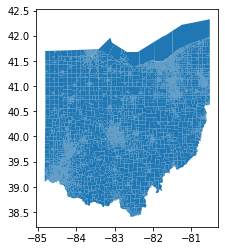

In [9]:
wip_pber_merge.plot()

In [10]:
merge = wip_pber_merge.copy()
election_cols = sorted(list(merge.columns[merge.columns.str.startswith("G")]))
merge["COUNTYNM"] = merge["county"]
merge["COUNTYFP"] = merge["county"].str.lower().map(county_name_to_fips_dict)
merge["PRECINCT"] = merge["UNIQUE_ID"].str.split(pat="-").str[1]
merge[election_cols]=merge[election_cols].fillna(0)
assert merge[merge.columns[merge.columns.str.startswith("G")]].isna().any().all()==False

merge = merge[["UNIQUE_ID","COUNTYFP","COUNTYNM","PRECINCT","PRECCODE",]+election_cols+["geometry"]]

## Check PBER

In [11]:
merge["UNIQUE_ID"].nunique()

8941

In [12]:
#Check that no null values and that UNIQUE precinct identifier is in fact unique
assert merge["UNIQUE_ID"].isna().any()==False
assert merge["UNIQUE_ID"].nunique()==merge.shape[0]


#State, County, Precinct total vote checks adapted from pdv checks: https://github.com/nonpartisan-redistricting-datahub/pdv-resources/blob/main/pdv_functions.py
def statewide_totals_check(partner_df, partner_name, source_df, source_name, column_list):
    """Compares the totals of two election result dataframes at the statewide total level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
 
    Returns:
      difference list
    """
    print("***Statewide Totals Check***")
    diff_races=[]
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            if race not in diff_races:
                diff_races.append(race)
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\t"+ partner_name + ": "+str(partner_df[race].sum())+" votes")
            print("\t"+ source_name +": "+str(source_df[race].sum())+" votes")
        #else:
            #print(race + " is equal", "\t both dataframes " + str(partner_df[race].sum()))
    
    if (len(diff_races)==0):
        print("All contests match statewide!")
    elif (len(diff_races)>0):
        print("Contests with differences: ")
    
    return diff_races


def county_totals_check(partner_df, partner_name, source_df, source_name, column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      partner_name: String of what to call the partner in the print statement
      source_df: DataFrame of election results we are comparing to
      source_name: String of what to call the source in the print statement
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      difference list
    """
    
    print("\n***Countywide Totals Check***")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\t"+ partner_name + ": "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\t"+ source_name +": "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        #else:
            #print(race + " is equal across all counties")
            #if (full_print):
               # for val in diff[diff == 0].index.values.tolist():
                 #   county_similarities = diff[diff == 0]
                    #print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
    if (len(diff_counties)==0):
        print("All contests in all counties match!")
    elif (len(diff_counties)>0):
        print("Counties with differences: ")
        
    return diff_counties
        
    
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    """Checks a merged dataframe with two election results at the precinct level

    Args:
      merged_df: DataFrame with one set of election results joined to another
      column_list: List of races that there are votes for
      vest_on_left: Boolean specifying whether VEST data is on the left side of merged_df
      name_col: String of the column name to refer to precincts when a difference occurs
      print_level: Integer that specifies how large the vote difference in a precinct must be to be printed

    Returns:
      list of differences
    """
    print("\n***Precinct Totals Check***")
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
            
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1

    print("\nThere are ", len(merged_df.index)," total rows")
    
    if(len(diff_values)!=0):
        print(matching_rows," of these rows are the same")
        print("\nAll precincts containing differences:")
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
        print("\nThe max difference between any one shared column in a row is: ", max_diff)
        count_big_diff = len([i for i in diff_values if i > 10])
        print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    else:
        print(matching_rows," of these rows are the same")
    
    diff_list.sort()
    
    return diff_list
    
    
partner_df = er22.copy()
partner_df["COUNTYNM"] = partner_df["County"].str.upper()
partner_name = "original ER 22"
source_df = merge.copy()
source_name = "PBER 22"
column_list = election_cols
county_col = "COUNTYNM"
#Running inner join because of expected nan value for ZZZ precincts
merged_df = pd.merge(merge, er22, on = ["UNIQUE_ID"], how = "inner", indicator=True)
vest_on_left = False
name_col = "UNIQUE_ID"


#All matches statewide and county levels
statewide_totals_check(partner_df, partner_name, source_df, source_name, column_list)
county_totals_check(partner_df, partner_name, source_df, source_name, column_list,county_col,full_print=False)
precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0)

***Statewide Totals Check***
All contests match statewide!

***Countywide Totals Check***
All contests in all counties match!

***Precinct Totals Check***

There are  8933  total rows
8933  of these rows are the same


[]

## Geo-Overlap Check and Cleaning -- NOT WORKING SO EXCLUDED FOR NOW

In [13]:
import maup


#Block/precinct overlaps identified by Peter 6/29/2023
can_fix_w_automation = {'390599780003013': ['MUSKINGUM-PRECINCT RICH HILL', 'GUERNSEY-ACO'],
 '391279663011065': ['HOCKING-PRECINCT FALLS 2', 'PERRY-AAT'],
 '390070010011021': ['GEAUGA-PRECINCT THOMPSON TWP B', 'ASHTABULA-AES'],
 '390250401013019': ['BROWN-PERRY TWP SOUTH', 'CLERMONT-JACKSON TOWNSHIP A'],
 '390610260012001': ['HAMILTON-HARR TWP BB', 'BUTLER-MORGAN TWP 1'],
 '390610260012003': ['HAMILTON-HARR TWP BB', 'BUTLER-MORGAN TWP 1'],
 '390610260012002': ['HAMILTON-HARR TWP BB', 'BUTLER-MORGAN TWP 1'],
 '391650320091054': ['HAMILTON-SYMMES I', 'WARREN-AFH'],
 '391650320091053': ['HAMILTON-SYMMES I', 'WARREN-AFH'],
 '390339742004057': ['MARION-PRECINCT SCOTT TULLY', 'CRAWFORD-ABX'],
 '391650320062019': ['HAMILTON-SYMMES D', 'WARREN-ACB'],
 '390719552003050': ['BROWN-WASHINGTON TWP', 'HIGHLAND-AAS'],
 '391439621001012': ['ERIE-PRECINCT MAR TWP #2', 'SANDUSKY-ACX']}

requires_additional_checking = {'391093801001014': ['MIAMI-PRECINCT BETHEL WEST',
  'MIAMI-PRECINCT TIPP CITY H'],
 '390430417013007': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390430417023029': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390430417011015': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390430417011016': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390430417023027': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390430417011005': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390430417023023': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390430417011003': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390430417011002': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390351561011018': ['CUYAHOGA-INDEPENDENCE-00-D',
  'CUYAHOGA-VALLEY VIEW-00-A'],
 '390351351061030': ['CUYAHOGA-BRECKSVILLE-00-F', 'CUYAHOGA-BRECKSVILLE-00-G'],
 '390351731073015': ['CUYAHOGA-MIDDLEBURG HEIGHTS-01-B',
  'CUYAHOGA-MIDDLEBURG HEIGHTS-02-B'],
 '390351351061028': ['CUYAHOGA-BRECKSVILLE-00-F', 'CUYAHOGA-BRECKSVILLE-00-G'],
 '390351351061029': ['CUYAHOGA-BRECKSVILLE-00-F', 'CUYAHOGA-BRECKSVILLE-00-G'],
 '390170151001010': ['BUTLER-LIBERTY TWP 1', 'BUTLER-MADISON TWP 5'],
 '390170111233019': ['BUTLER-WEST CHESTER TWP 35',
  'BUTLER-WEST CHESTER TWP 39'],
 '390299514023041': ['COLUMBIANA-PRECINCT LISBON VIL NORTH',
  'COLUMBIANA-PRECINCT CENTER TWP NORTH'],
 '391730213002041': ['WOOD-GRAND RAPIDS TWP GR VILL',
  'WOOD-GRAND RAPIDS TWP PARK'],
 '391093801001015': ['MIAMI-PRECINCT BETHEL WEST',
  'MIAMI-PRECINCT TIPP CITY H'],
 '390430417011014': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390299502004025': ['COLUMBIANA-PRECINCT FAIRFIELD TWP NORTH',
  'COLUMBIANA-PRECINCT FAIRFIELD TWP CENTER'],
 '390430417011013': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390430417023024': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390170101052004': ['BUTLER-OXFORD 2', 'BUTLER-OXFORD TWP 3'],
 '390430417011006': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390430417011007': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390430417023026': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390430417011017': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390430417011019': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390430417011018': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390430417011004': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390430417023025': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390430417011011': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390430417013008': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390430417013009': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390430417011001': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1'],
 '390430417011012': ['ERIE-PRECINCT CAST VILL', 'ERIE-PRECINCT MAR TWP #1']}



In [17]:
def clean_gdf(block_cnty, pct_1_id, pct_1_cnty, pct_2_id, pct_2_cnty):
    print("Working on precinct #1:", pct_1_id)
    print("Working on precinct #2:", pct_2_id)
    pct_1 = oh_gen.loc[oh_gen["UNIQUE_ID"]==pct_1_id]
    pct_2 = oh_gen.loc[oh_gen["UNIQUE_ID"]==pct_2_id]
    ax = pct_1.plot()
    ax.set_title(pct_1_id)
    ax_2 = pct_2.plot()
    ax_2.set_title(pct_2_id)
    
    if (block_cnty == pct_1_cnty):
        diff = gp.overlay(pct_2, pct_1, how = "difference", keep_geom_type=False)
        print(diff)
        oh_gen.loc[oh_gen["UNIQUE_ID"]==pct_2_id, "geometry"] = diff.geometry
    elif (block_cnty == pct_2_cnty):
        diff = gp.overlay(pct_1, pct_2, how = "difference", keep_geom_type=False)
        print(diff)
        oh_gen.loc[oh_gen["UNIQUE_ID"]==pct_1_id, "geometry"] = diff.geometry
    else:
        raise ValueError
    pct_1 = oh_gen.loc[oh_gen["UNIQUE_ID"]==pct_1_id]
    pct_2 = oh_gen.loc[oh_gen["UNIQUE_ID"]==pct_2_id]
    ax = pct_1.plot()
    ax.set_title(pct_1_id)
    ax_2 = pct_2.plot()
    ax_2.set_title(pct_2_id)

Working on precinct #1: MUSKINGUM-PRECINCT RICH HILL
Working on precinct #2: GUERNSEY-ACO
                      UNIQUE_ID COUNTYFP   COUNTYNM            PRECINCT  \
0  MUSKINGUM-PRECINCT RICH HILL      119  MUSKINGUM  PRECINCT RICH HILL   

  PRECCODE  G22ATGDCRO  G22ATGRYOS  G22AUDDSAP  G22AUDRFAB  G22CJUDBRU  ...  \
0      ACM        36.0       190.0        36.0       187.0        39.0  ...   

   GSU25DDEM  GSU25RWYS  GSU27DGOE  GSU27RROE  GSU29RSCH  GSU31RLAN  \
0        0.0        0.0        0.0        0.0        0.0      189.0   

   GSU33DHAG  GSU33RRUL                                           geometry  \
0        0.0        0.0  POLYGON ((-9100269.297 4856140.737, -9100085.4...   

   precinct_area  
0   1.617848e+08  

[1 rows x 256 columns]
Working on precinct #1: HOCKING-PRECINCT FALLS 2
Working on precinct #2: PERRY-AAT
                  UNIQUE_ID COUNTYFP COUNTYNM          PRECINCT PRECCODE  \
0  HOCKING-PRECINCT FALLS 2      073  HOCKING  PRECINCT FALLS 2      AAN   

  

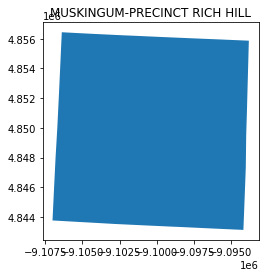

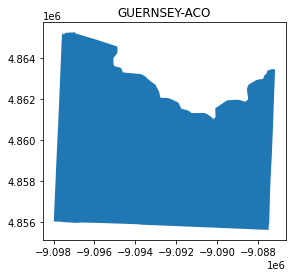

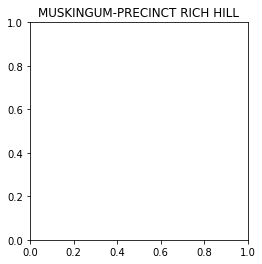

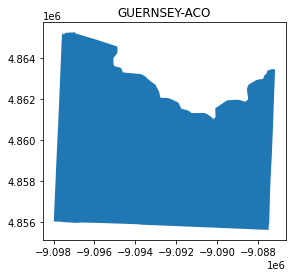

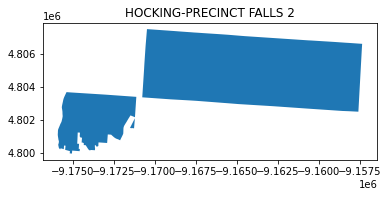

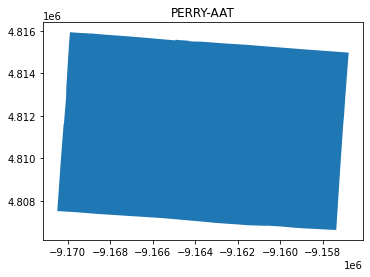

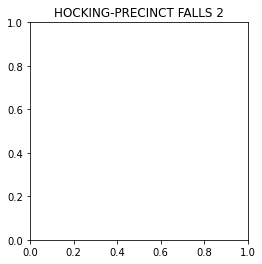

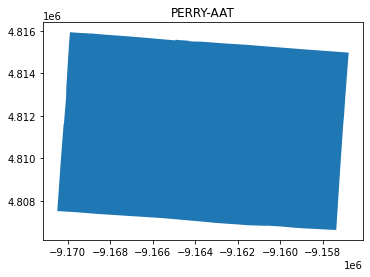

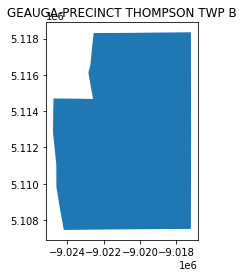

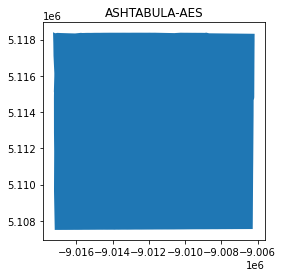

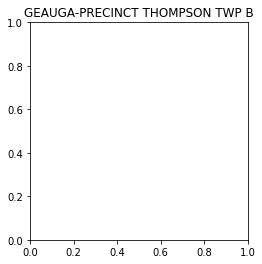

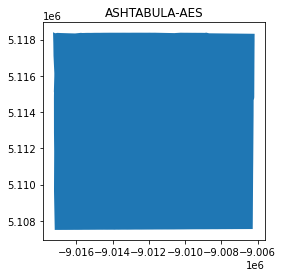

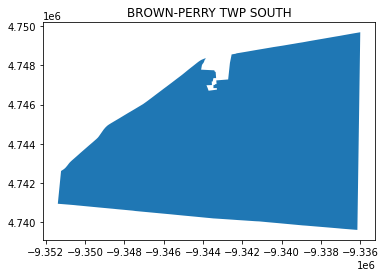

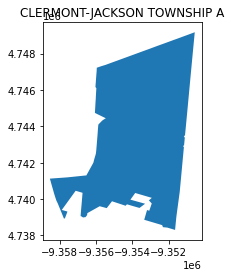

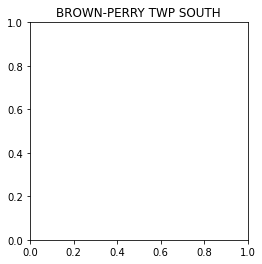

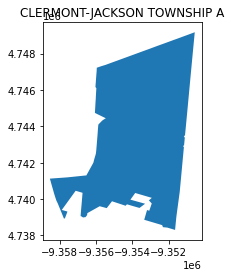

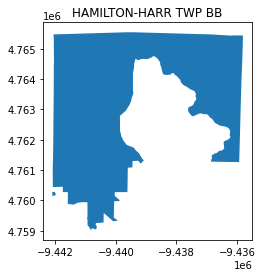

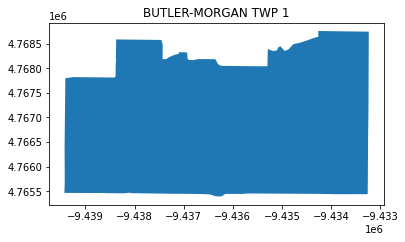

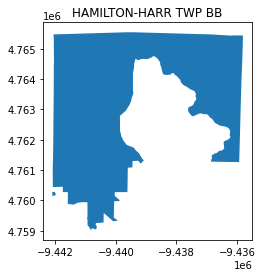

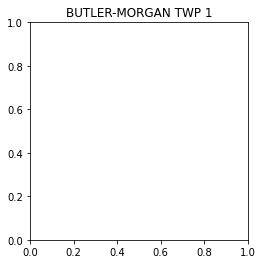

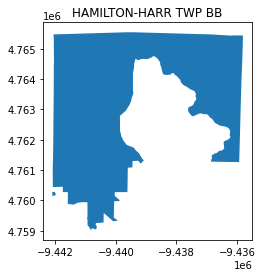

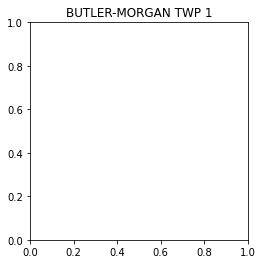

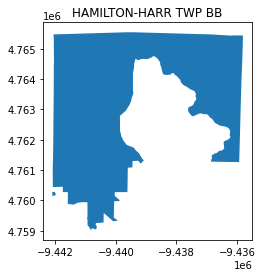

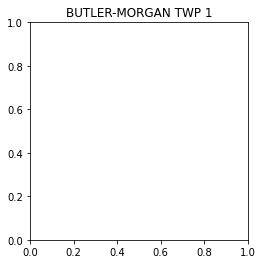

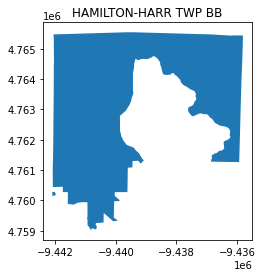

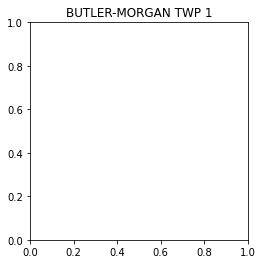

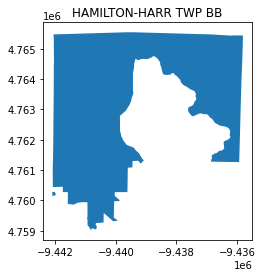

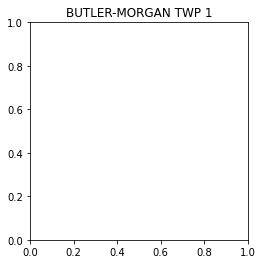

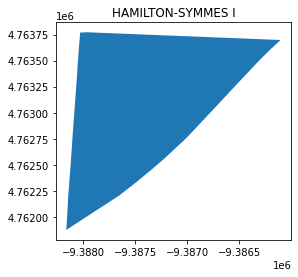

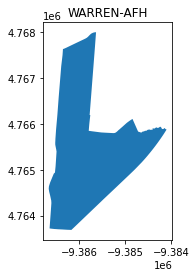

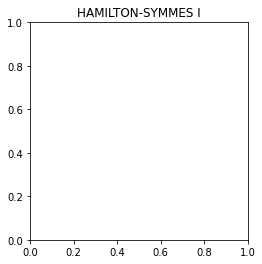

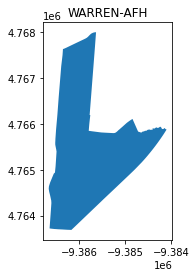

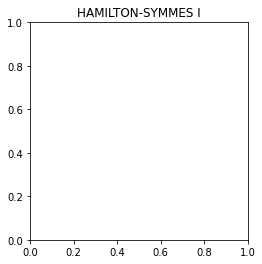

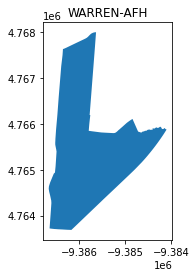

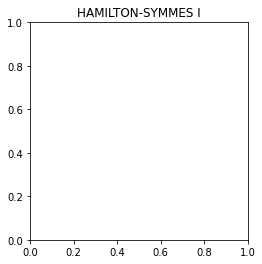

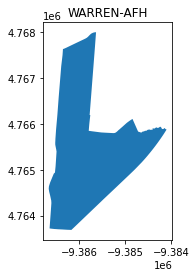

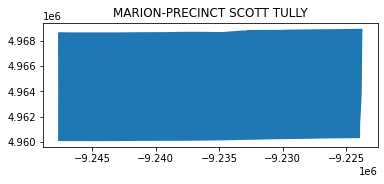

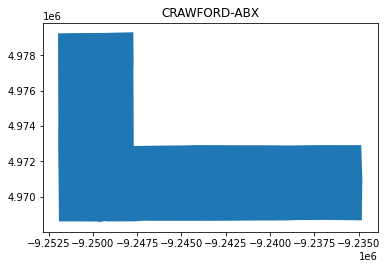

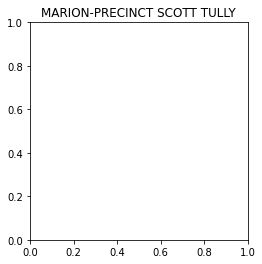

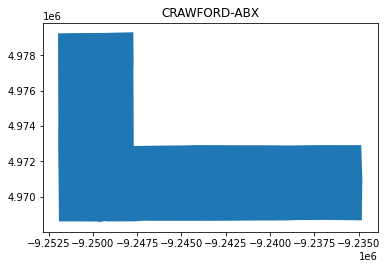

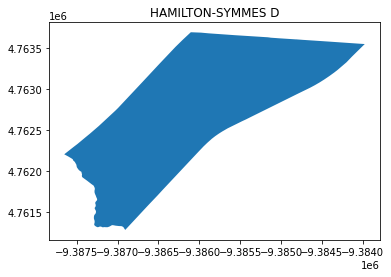

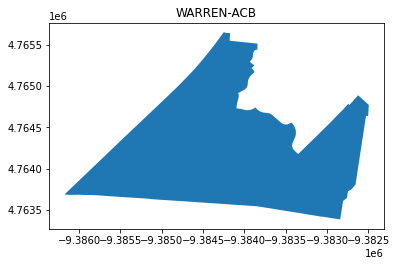

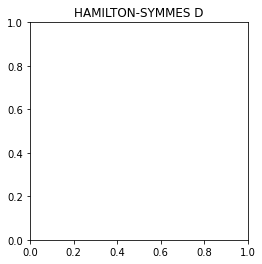

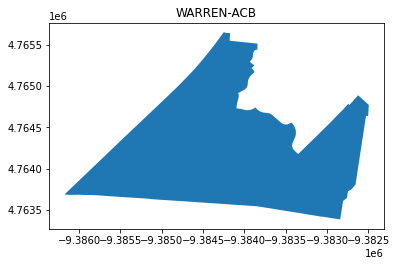

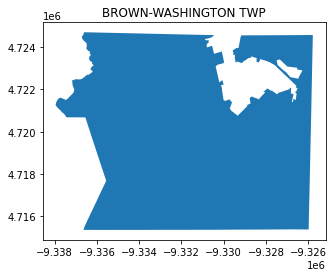

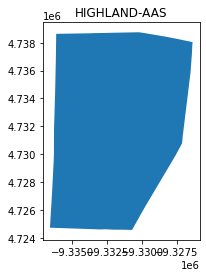

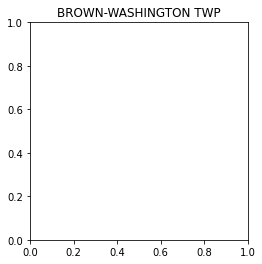

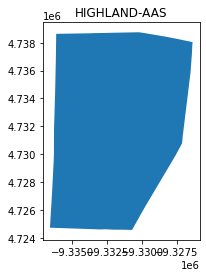

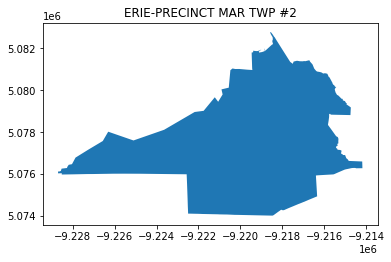

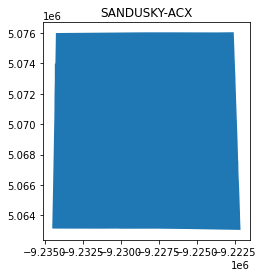

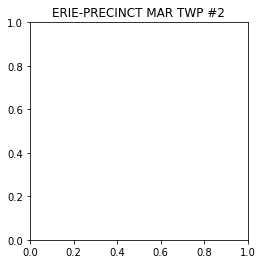

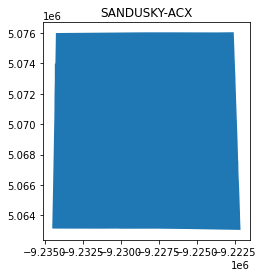

In [18]:
# Load in OH precincts
oh_gen = merge.copy(deep=True)

# Load in OH blocks
oh_blocks = gp.read_file("./oh_pl2020_b/oh_pl2020_p1_b.shp")[['GEOID20','P0010001', 'geometry']] #raw_data/census/2020_TIGER_B/oh_b_2020_bound/oh_b_2020_bound.shp)

oh_gen = oh_gen.to_crs(3857)
oh_blocks = oh_blocks.to_crs(3857)

oh_gen["precinct_area"] = oh_gen.area
oh_blocks["block_area"] = oh_blocks.area


for key, val in can_fix_w_automation.items():
    clean_gdf(key[2:5], val[0], oh_gen.loc[oh_gen["UNIQUE_ID"]==val[0],"COUNTYFP"].values[0], val[1], oh_gen.loc[oh_gen["UNIQUE_ID"]==val[1],"COUNTYFP"].values[0])

In [19]:
merge[merge["geometry"].isna()]

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,PRECCODE,G22ATGDCRO,G22ATGRYOS,G22AUDDSAP,G22AUDRFAB,G22CJUDBRU,...,GSU23RSIM,GSU25DDEM,GSU25RWYS,GSU27DGOE,GSU27RROE,GSU29RSCH,GSU31RLAN,GSU33DHAG,GSU33RRUL,geometry


In [20]:
oh_gen[oh_gen["geometry"].isna()]

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,PRECCODE,G22ATGDCRO,G22ATGRYOS,G22AUDDSAP,G22AUDRFAB,G22CJUDBRU,...,GSU25DDEM,GSU25RWYS,GSU27DGOE,GSU27RROE,GSU29RSCH,GSU31RLAN,GSU33DHAG,GSU33RRUL,geometry,precinct_area
316,GEAUGA-PRECINCT THOMPSON TWP B,055,GEAUGA,PRECINCT THOMPSON TWP B,ACX,122.0,331.0,139.0,307.0,149.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,7.350038e+07
904,HAMILTON-SYMMES D,061,HAMILTON,SYMMES D,BNP,296.0,326.0,299.0,318.0,311.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,3.591261e+06
919,HAMILTON-SYMMES I,061,HAMILTON,SYMMES I,BNU,247.0,219.0,248.0,216.0,258.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,2.017347e+06
979,HOCKING-PRECINCT FALLS 2,073,HOCKING,PRECINCT FALLS 2,AAN,76.0,314.0,83.0,303.0,88.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,6.752639e+07
1163,MARION-PRECINCT SCOTT TULLY,101,MARION,PRECINCT SCOTT TULLY,ADI,67.0,469.0,82.0,452.0,86.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,2.048861e+08
1273,MUSKINGUM-PRECINCT RICH HILL,119,MUSKINGUM,PRECINCT RICH HILL,ACM,36.0,190.0,36.0,187.0,39.0,...,0.0,0.0,0.0,0.0,0.0,189.0,0.0,0.0,None,1.617848e+08
1410,BROWN-PERRY TWP SOUTH,015,BROWN,PERRY TWP SOUTH,AAW,66.0,370.0,64.0,370.0,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,1.067251e+08
1422,BROWN-WASHINGTON TWP,015,BROWN,WASHINGTON TWP,ACW,82.0,379.0,85.0,371.0,95.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,8.994514e+07
1620,BUTLER-MORGAN TWP 1,017,BUTLER,MORGAN TWP 1,AHJ,68.0,303.0,70.0,299.0,76.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,1.766269e+07
2876,ERIE-PRECINCT MAR TWP #2,043,ERIE,PRECINCT MAR TWP #2,ACR,105.0,239.0,110.0,232.0,126.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,5.595374e+07


In [21]:
'''
The above null values are caused by Geopandas 10.2 not accepting the diff function as geopandas 9.0 does. As a result, these will be manually added in.
Matches to manually add to baf to avoid these null geos:
{'390599780003013': 'GUERNSEY-ACO',
 '391279663011065': 'PERRY-AAT',
 '390070010011021': 'ASHTABULA-AES',
 '390250401013019': 'CLERMONT-JACKSON TOWNSHIP A',
 '390610260012001': 'HAMILTON-HARR TWP BB',
 '390610260012003': 'HAMILTON-HARR TWP BB',
 '390610260012002': 'HAMILTON-HARR TWP BB',
 '391650320091054': 'WARREN-AFH',
 '391650320091053': 'WARREN-AFH',
 '390339742004057': 'CRAWFORD-ABX',
 '391650320062019': 'WARREN-ACB',
 '390719552003050': 'HIGHLAND-AAS',
 '391439621001012': 'SANDUSKY-ACX'}'''

"Matches to manually add to baf to avoid these null geos:\n{'390599780003013': 'GUERNSEY-ACO',\n '391279663011065': 'PERRY-AAT',\n '390070010011021': 'ASHTABULA-AES',\n '390250401013019': 'CLERMONT-JACKSON TOWNSHIP A',\n '390610260012001': 'HAMILTON-HARR TWP BB',\n '390610260012003': 'HAMILTON-HARR TWP BB',\n '390610260012002': 'HAMILTON-HARR TWP BB',\n '391650320091054': 'WARREN-AFH',\n '391650320091053': 'WARREN-AFH',\n '390339742004057': 'CRAWFORD-ABX',\n '391650320062019': 'WARREN-ACB',\n '390719552003050': 'HIGHLAND-AAS',\n '391439621001012': 'SANDUSKY-ACX'}"

### Fix Erie overlap

In [22]:
erie_cast_vill_prec = oh_gen[oh_gen["UNIQUE_ID"]=="ERIE-PRECINCT CAST VILL"]
erie_mar_twp_prec_overfill = oh_gen[oh_gen["UNIQUE_ID"]=="ERIE-PRECINCT MAR TWP #1"]
erie_mar_twp_prec_cutout = gp.overlay(erie_mar_twp_prec_overfill, erie_cast_vill_prec, how="difference",keep_geom_type = False)

'''
"ERIE-PRECINCT MAR TWP #1" overlaps and completely contains "ERIE-PRECINCT CAST VILL" in the original ERIE shapefile. 
Here, the overly-filled "ERIE-PRECINCT MAR TWP #1" shape is replaced with "ERIE-PRECINCT CAST VILL".
This should eliminate overlap issues for erie.
'''

oh_gen = oh_gen.loc[oh_gen["UNIQUE_ID"]!="ERIE-PRECINCT MAR TWP #1"]
oh_gen = gp.GeoDataFrame(pd.concat([oh_gen, erie_mar_twp_prec_cutout], ignore_index=True), crs=3857)

In [23]:
maup.assign(oh_blocks[oh_blocks["GEOID20"].isin(requires_additional_checking)], oh_gen[(oh_gen["COUNTYNM"]=="ERIE")&(oh_gen["UNIQUE_ID"]!="ERIE-PRECINCT MAR TWP #2")].to_crs(3857))

1583      2861.0
5622      2861.0
10052     2861.0
10055     2861.0
18971     2861.0
30254        NaN
35885     2861.0
38930        NaN
43113        NaN
58603        NaN
78911     2861.0
87508     2861.0
99813        NaN
100901    2861.0
107329    2861.0
117691    2861.0
122031    2861.0
146224    2861.0
147539       NaN
152417    2861.0
167113       NaN
169532    2861.0
169821    2861.0
178229    2861.0
179813    2861.0
189394    2861.0
195472    2861.0
199078       NaN
204527    2861.0
211099    2861.0
217385    2861.0
221264       NaN
246309       NaN
246562       NaN
251748    2861.0
252039    2861.0
255245       NaN
255985       NaN
dtype: float64

### Set up to address rest of overlaps

In [24]:
#oh_blocks_checking = oh_blocks[oh_blocks["GEOID20"].isin(requires_additional_checking.keys())]
oh_blocks_checks = oh_blocks[(oh_blocks["GEOID20"].isin(requires_additional_checking))&(oh_blocks["GEOID20"].str.slice(start=3, stop=5)!="43")]
checks_intersection = gp.overlay(oh_blocks_checks, oh_gen, how="intersection")

In [25]:
checks_intersection.shape

(26, 259)

In [26]:
checks_intersect_ser = checks_intersection["GEOID20"].value_counts()
one_geoid = list(checks_intersect_ser[checks_intersect_ser == 1].index)

In [27]:
self_intersection_filtered = checks_intersection[~checks_intersection["GEOID20"].isin(one_geoid)]

In [28]:
self_intersection_filtered.shape

(26, 259)

In [29]:
self_intersection_filtered["intersection_area"] = self_intersection_filtered.area
self_intersection_filtered["intersection_pct"] = self_intersection_filtered["intersection_area"]/self_intersection_filtered["block_area"]

In [30]:
ser_2 = self_intersection_filtered[self_intersection_filtered["intersection_pct"]>=.5]["GEOID20"].value_counts()

In [31]:
possible_problems = list(ser_2[ser_2>=2].index)

In [32]:
ser_2[ser_2>=2].index

Index(['390299502004025', '390299514023041', '390170101052004',
       '390170111233019', '390351561011018', '391730213002041',
       '390170151001010', '390351731073015', '391093801001014',
       '391093801001015', '390351351061029', '390351351061028',
       '390351351061030'],
      dtype='object')

In [33]:
ser_2

390299502004025    2
390299514023041    2
390170101052004    2
390170111233019    2
390351561011018    2
391730213002041    2
390170151001010    2
390351731073015    2
391093801001014    2
391093801001015    2
390351351061029    2
390351351061028    2
390351351061030    2
Name: GEOID20, dtype: int64

In [34]:
last_filter = self_intersection_filtered[self_intersection_filtered["intersection_pct"]>=.5]

In [35]:
last_filter[last_filter["P0010001"]>0].to_file("./overlap_checkout/self_intersection_w_pop.shp")

In [36]:
#last_filter.to_file("./overlap_checkout/self_intersection_blocks.shp")

In [37]:
last_filter[last_filter["P0010001"]>0]

,GEOID20,P0010001,block_area,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,PRECCODE,G22ATGDCRO,G22ATGRYOS,...,GSU27DGOE,GSU27RROE,GSU29RSCH,GSU31RLAN,GSU33DHAG,GSU33RRUL,precinct_area,geometry,intersection_area,intersection_pct
10,391730213002041,10,4241.372442,WOOD-GRAND RAPIDS TWP GR VILL,173,WOOD,GRAND RAPIDS TWP GR VILL,ABU,134.0,235.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.382915e+06,"POLYGON ((-9334616.752 5073439.085, -9334576.9...",3853.551018,0.908562
11,391730213002041,10,4241.372442,WOOD-GRAND RAPIDS TWP PARK,173,WOOD,GRAND RAPIDS TWP PARK,ABV,102.0,213.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.853175e+07,"POLYGON ((-9334616.752 5073439.085, -9334576.9...",4241.372442,1.000000


#### Fix 391730213002041 pop = 10 in Wood County

In [38]:
wood_gr_vill_prec = oh_gen[oh_gen["UNIQUE_ID"]=="WOOD-GRAND RAPIDS TWP GR VILL"].to_crs(3857)
wood_park_prec = oh_gen[oh_gen["UNIQUE_ID"]=="WOOD-GRAND RAPIDS TWP PARK"].to_crs(3857)

wood_park_prec_cutout = gp.overlay(wood_park_prec,wood_gr_vill_prec,  how="difference",keep_geom_type = False)

'''
"WOOD-GRAND RAPIDS TWP GR VILL" overlaps "WOOD-GRAND RAPIDS TWP PARK" at block 391730213002041
In voterfile there is a voter to the right of this block assigned to TWP GR VIL,
so here the overlap is left assigned to "WOOD-GRAND RAPIDS TWP GR VILL" and cut out from "WOOD-GRAND RAPIDS TWP PARK"
'''

oh_gen = oh_gen.loc[oh_gen["UNIQUE_ID"]!="WOOD-GRAND RAPIDS TWP PARK"]
oh_gen = gp.GeoDataFrame(pd.concat([oh_gen, wood_park_prec_cutout], ignore_index=True), crs=3857)

##### Losing geometries along the way because .diff doesn't work with geopandas 10.2, but other parts of my code do not work with geopandas 9.0 used by peter to make diff code

#### Fix 0-pop block overlaps

In [39]:
last_filter["UNIQUE_ID"].nunique()

20

In [40]:
last_filter["GEOID20"].value_counts()

390299502004025    2
390299514023041    2
390170101052004    2
390170111233019    2
390351561011018    2
391730213002041    2
390170151001010    2
390351731073015    2
391093801001014    2
391093801001015    2
390351351061029    2
390351351061028    2
390351351061030    2
Name: GEOID20, dtype: int64

In [41]:
for geoid in last_filter["GEOID20"]:
    print(geoid)

390299502004025
390299502004025
390299514023041
390299514023041
390170101052004
390170101052004
390170111233019
390170111233019
390351561011018
390351561011018
391730213002041
391730213002041
390170151001010
390170151001010
390351731073015
390351731073015
391093801001014
391093801001015
391093801001014
391093801001015
390351351061029
390351351061028
390351351061030
390351351061029
390351351061028
390351351061030


In [42]:
for prec in last_filter["UNIQUE_ID"]:
    print(prec)

COLUMBIANA-PRECINCT FAIRFIELD TWP NORTH
COLUMBIANA-PRECINCT FAIRFIELD TWP CENTER
COLUMBIANA-PRECINCT LISBON VIL NORTH
COLUMBIANA-PRECINCT CENTER TWP NORTH
BUTLER-OXFORD 2
BUTLER-OXFORD TWP 3
BUTLER-WEST CHESTER TWP 35
BUTLER-WEST CHESTER TWP 39
CUYAHOGA-INDEPENDENCE-00-D
CUYAHOGA-VALLEY VIEW-00-A
WOOD-GRAND RAPIDS TWP GR VILL
WOOD-GRAND RAPIDS TWP PARK
BUTLER-LIBERTY TWP 1
BUTLER-MADISON TWP 5
CUYAHOGA-MIDDLEBURG HEIGHTS-01-B
CUYAHOGA-MIDDLEBURG HEIGHTS-02-B
MIAMI-PRECINCT BETHEL WEST
MIAMI-PRECINCT BETHEL WEST
MIAMI-PRECINCT TIPP CITY H
MIAMI-PRECINCT TIPP CITY H
CUYAHOGA-BRECKSVILLE-00-F
CUYAHOGA-BRECKSVILLE-00-F
CUYAHOGA-BRECKSVILLE-00-F
CUYAHOGA-BRECKSVILLE-00-G
CUYAHOGA-BRECKSVILLE-00-G
CUYAHOGA-BRECKSVILLE-00-G


In [43]:
#last_filter[(last_filter["UNIQUE_ID"]=="COLUMBIANA-PRECINCT FAIRFIELD TWP NORTH")|(last_filter["UNIQUE_ID"]=="COLUMBIANA-PRECINCT FAIRFIELD TWP CENTER")]
columbiana1 = oh_gen[oh_gen["UNIQUE_ID"]=="COLUMBIANA-PRECINCT FAIRFIELD TWP NORTH"].to_crs(3857)
columbiana2 = oh_gen[oh_gen["UNIQUE_ID"]=="COLUMBIANA-PRECINCT FAIRFIELD TWP CENTER"].to_crs(3857)
columbiana1_2_cutout = gp.overlay(columbiana1, columbiana2,  how="difference",keep_geom_type = False)

oh_gen = oh_gen.loc[oh_gen["UNIQUE_ID"]!="COLUMBIANA-PRECINCT FAIRFIELD TWP NORTH"]
oh_gen = gp.GeoDataFrame(pd.concat([oh_gen, columbiana1_2_cutout], ignore_index=True), crs=3857)


#last_filter[(last_filter["UNIQUE_ID"]=="COLUMBIANA-PRECINCT LISBON VIL NORTH")|(last_filter["UNIQUE_ID"]=="COLUMBIANA-PRECINCT CENTER TWP NORTH")]
columbiana3 = oh_gen[oh_gen["UNIQUE_ID"]=="COLUMBIANA-PRECINCT LISBON VIL NORTH"].to_crs(3857)
columbiana4 = oh_gen[oh_gen["UNIQUE_ID"]=="COLUMBIANA-PRECINCT CENTER TWP NORTH"].to_crs(3857)
columbiana3_4_cutout = gp.overlay(columbiana1, columbiana2,  how="difference",keep_geom_type = False)

oh_gen = oh_gen.loc[oh_gen["UNIQUE_ID"]!="COLUMBIANA-PRECINCT LISBON VIL NORTH"]
oh_gen = gp.GeoDataFrame(pd.concat([oh_gen, columbiana3_4_cutout], ignore_index=True), crs=3857)


#last_filter[(last_filter["UNIQUE_ID"]=="BUTLER-OXFORD 2")|(last_filter["UNIQUE_ID"]=="BUTLER-OXFORD TWP 3")]
butler1 = oh_gen[oh_gen["UNIQUE_ID"]=="BUTLER-OXFORD 2"].to_crs(3857)
butler2 = oh_gen[oh_gen["UNIQUE_ID"]=="BUTLER-OXFORD TWP 3"].to_crs(3857)
butler1_2_cutout = gp.overlay(butler1, butler2,  how="difference",keep_geom_type = False)

oh_gen = oh_gen.loc[oh_gen["UNIQUE_ID"]!="BUTLER-OXFORD 2"]
oh_gen = gp.GeoDataFrame(pd.concat([oh_gen, butler1_2_cutout], ignore_index=True), crs=3857)


#last_filter[(last_filter["UNIQUE_ID"]=="BUTLER-WEST CHESTER TWP 35")|(last_filter["UNIQUE_ID"]=="BUTLER-WEST CHESTER TWP 39")]
butler3 = oh_gen[oh_gen["UNIQUE_ID"]=="BUTLER-WEST CHESTER TWP 35"].to_crs(3857)
butler4 = oh_gen[oh_gen["UNIQUE_ID"]=="BUTLER-WEST CHESTER TWP 39"].to_crs(3857)
butler3_4_cutout = gp.overlay(butler3, butler4,  how="difference",keep_geom_type = False)

oh_gen = oh_gen.loc[oh_gen["UNIQUE_ID"]!="BUTLER-WEST CHESTER TWP 35"]
oh_gen = gp.GeoDataFrame(pd.concat([oh_gen, butler3_4_cutout], ignore_index=True), crs=3857)


#CUYAHOGA-INDEPENDENCE-00-D, CUYAHOGA-VALLEY VIEW-00-A
cuyahoga1 = oh_gen[oh_gen["UNIQUE_ID"]=="CUYAHOGA-INDEPENDENCE-00-D"].to_crs(3857)
cuyahoga2 = oh_gen[oh_gen["UNIQUE_ID"]=="CUYAHOGA-VALLEY VIEW-00-A"].to_crs(3857)
cuyahoga1_2_cutout = gp.overlay(cuyahoga1, cuyahoga2,  how="difference",keep_geom_type = False)

oh_gen = oh_gen.loc[oh_gen["UNIQUE_ID"]!="CUYAHOGA-INDEPENDENCE-00-D"]
oh_gen = gp.GeoDataFrame(pd.concat([oh_gen, cuyahoga1_2_cutout], ignore_index=True), crs=3857)

#BUTLER-LIBERTY TWP 1, BUTLER-MADISON TWP 5
butler5 = oh_gen[oh_gen["UNIQUE_ID"]=="BUTLER-LIBERTY TWP 1"].to_crs(3857)
butler6 = oh_gen[oh_gen["UNIQUE_ID"]=="BUTLER-MADISON TWP 5"].to_crs(3857)
butler5_6_cutout = gp.overlay(butler5, butler6,  how="difference",keep_geom_type = False)

oh_gen = oh_gen.loc[oh_gen["UNIQUE_ID"]!="BUTLER-LIBERTY TWP 1"]
oh_gen = gp.GeoDataFrame(pd.concat([oh_gen, butler5_6_cutout], ignore_index=True), crs=3857)

#CUYAHOGA-MIDDLEBURG HEIGHTS-01-B, CUYAHOGA-MIDDLEBURG HEIGHTS-02-B
cuyahoga3 = oh_gen[oh_gen["UNIQUE_ID"]=="CUYAHOGA-MIDDLEBURG HEIGHTS-01-B"].to_crs(3857)
cuyahoga4 = oh_gen[oh_gen["UNIQUE_ID"]=="CUYAHOGA-MIDDLEBURG HEIGHTS-02-B"].to_crs(3857)
cuyahoga3_4_cutout = gp.overlay(cuyahoga3, cuyahoga4,  how="difference",keep_geom_type = False)

oh_gen = oh_gen.loc[oh_gen["UNIQUE_ID"]!="CUYAHOGA-MIDDLEBURG HEIGHTS-01-B"]
oh_gen = gp.GeoDataFrame(pd.concat([oh_gen, cuyahoga3_4_cutout], ignore_index=True), crs=3857)

#MIAMI-PRECINCT BETHEL WEST, MIAMI-PRECINCT BETHEL WEST
miami1 = oh_gen[oh_gen["UNIQUE_ID"]=="MIAMI-PRECINCT BETHEL WEST"].to_crs(3857)
miami2 = oh_gen[oh_gen["UNIQUE_ID"]=="MIAMI-PRECINCT TIPP CITY H"].to_crs(3857)
miami1_2_cutout = gp.overlay(miami1, miami2,  how="difference",keep_geom_type = False)

oh_gen = oh_gen.loc[oh_gen["UNIQUE_ID"]!="MIAMI-PRECINCT BETHEL WEST"]
oh_gen = gp.GeoDataFrame(pd.concat([oh_gen, cuyahoga3_4_cutout], ignore_index=True), crs=3857)

#CUYAHOGA-BRECKSVILLE-00-F, CUYAHOGA-BRECKSVILLE-00-G
cuyahoga5 = oh_gen[oh_gen["UNIQUE_ID"]=="CUYAHOGA-BRECKSVILLE-00-F"].to_crs(3857)
cuyahoga6 = oh_gen[oh_gen["UNIQUE_ID"]=="CUYAHOGA-BRECKSVILLE-00-G"].to_crs(3857)
cuyahoga5_6_cutout = gp.overlay(cuyahoga5, cuyahoga6,  how="difference",keep_geom_type = False)

oh_gen = oh_gen.loc[oh_gen["UNIQUE_ID"]!="CUYAHOGA-BRECKSVILLE-00-F"]
oh_gen = gp.GeoDataFrame(pd.concat([oh_gen, cuyahoga5_6_cutout], ignore_index=True), crs=3857)

#Taken care of above: WOOD-GRAND RAPIDS TWP GR VILL, WOOD-GRAND RAPIDS TWP PARK

In [44]:
oh_gen[(oh_gen["geometry"].isna())&(oh_gen["COUNTYNM"]!="LORAIN")]

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,PRECCODE,G22ATGDCRO,G22ATGRYOS,G22AUDDSAP,G22AUDRFAB,G22CJUDBRU,...,GSU25DDEM,GSU25RWYS,GSU27DGOE,GSU27RROE,GSU29RSCH,GSU31RLAN,GSU33DHAG,GSU33RRUL,geometry,precinct_area
314,GEAUGA-PRECINCT THOMPSON TWP B,055,GEAUGA,PRECINCT THOMPSON TWP B,ACX,122.0,331.0,139.0,307.0,149.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,7.350038e+07
902,HAMILTON-SYMMES D,061,HAMILTON,SYMMES D,BNP,296.0,326.0,299.0,318.0,311.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,3.591261e+06
917,HAMILTON-SYMMES I,061,HAMILTON,SYMMES I,BNU,247.0,219.0,248.0,216.0,258.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,2.017347e+06
977,HOCKING-PRECINCT FALLS 2,073,HOCKING,PRECINCT FALLS 2,AAN,76.0,314.0,83.0,303.0,88.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,6.752639e+07
1161,MARION-PRECINCT SCOTT TULLY,101,MARION,PRECINCT SCOTT TULLY,ADI,67.0,469.0,82.0,452.0,86.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,2.048861e+08
1271,MUSKINGUM-PRECINCT RICH HILL,119,MUSKINGUM,PRECINCT RICH HILL,ACM,36.0,190.0,36.0,187.0,39.0,...,0.0,0.0,0.0,0.0,0.0,189.0,0.0,0.0,None,1.617848e+08
1408,BROWN-PERRY TWP SOUTH,015,BROWN,PERRY TWP SOUTH,AAW,66.0,370.0,64.0,370.0,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,1.067251e+08
1420,BROWN-WASHINGTON TWP,015,BROWN,WASHINGTON TWP,ACW,82.0,379.0,85.0,371.0,95.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,8.994514e+07
1617,BUTLER-MORGAN TWP 1,017,BUTLER,MORGAN TWP 1,AHJ,68.0,303.0,70.0,299.0,76.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,1.766269e+07
2867,ERIE-PRECINCT MAR TWP #2,043,ERIE,PRECINCT MAR TWP #2,ACR,105.0,239.0,110.0,232.0,126.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,5.595374e+07


In [ ]:
maup.assign(oh_blocks[oh_blocks["GEOID20"].isin(requires_additional_checking)], oh_gen[(oh_gen["COUNTYNM"]=="ERIE")&(oh_gen["UNIQUE_ID"]!="ERIE-PRECINCT MAR TWP #2")].to_crs(3857))

In [48]:
maup.assign(oh_blocks.to_crs(3857), oh_gen[~oh_gen["geometry"].isna()].to_crs(3857))

TopologyException: side location conflict at -9149043.8625458628 5082088.7979417117 0


AttributeError: 'PreparedGeometry' object has no attribute 'is_valid'

In [88]:
maup.assign(oh_blocks[(oh_blocks["GEOID20"].isin(requires_additional_checking))|(oh_blocks["GEOID20"].isin(can_fix_w_automation))], oh_gen[(~oh_gen["geometry"].isna())&(oh_gen["COUNTYNM"]!="LORAIN")&(oh_gen["COUNTYNM"]!="WOOD")].to_crs(3857))

1583      2853.0
5622      2853.0
10052     2853.0
10055     2853.0
14493     1744.0
18971     2853.0
26971     6500.0
30254      103.0
34653     8188.0
35885     2853.0
38930      106.0
43113     1636.0
52350      946.0
58603     1697.0
73971     5470.0
78911     2853.0
87508     2853.0
99813     2808.0
100901    2853.0
107329    2853.0
117691    2853.0
122031    2853.0
128306    6712.0
146224    2853.0
147539       NaN
152417    2853.0
167113    1566.0
169532    2853.0
169821    2853.0
178229    2853.0
179813    2853.0
183705     946.0
189394    2853.0
195472    2853.0
199078    2536.0
204527    2853.0
210486    6602.0
211099    2853.0
216848    5648.0
217385    2853.0
221264    2968.0
222532     946.0
236254    6602.0
240150    7307.0
246309    1937.0
246562    1937.0
251748    2853.0
252039    2853.0
255245    1937.0
255985    2968.0
256219    8352.0
dtype: float64

In [117]:
oh_gen[(~oh_gen["geometry"].isna())&(oh_gen["COUNTYNM"]!="WOOD")].to_crs(3857).to_file("./oh_2022_gen_prec_shp_wip/FOR_BAF.shp")

In [91]:
maup.assign(oh_blocks[(oh_blocks["GEOID20"].isin(requires_additional_checking))|(oh_blocks["GEOID20"].isin(can_fix_w_automation))], oh_gen[(~oh_gen["geometry"].isna())&(oh_gen["COUNTYNM"]!="WOOD")].to_crs(3857))

1583      2853.0
5622      2853.0
10052     2853.0
10055     2853.0
14493     1744.0
18971     2853.0
26971     6500.0
30254      103.0
34653     8188.0
35885     2853.0
38930      106.0
43113     1636.0
52350      946.0
58603     1697.0
73971     5470.0
78911     2853.0
87508     2853.0
99813     2808.0
100901    2853.0
107329    2853.0
117691    2853.0
122031    2853.0
128306    6712.0
146224    2853.0
147539       NaN
152417    2853.0
167113    1566.0
169532    2853.0
169821    2853.0
178229    2853.0
179813    2853.0
183705     946.0
189394    2853.0
195472    2853.0
199078    2536.0
204527    2853.0
210486    6602.0
211099    2853.0
216848    5648.0
217385    2853.0
221264    2968.0
222532     946.0
236254    6602.0
240150    7307.0
246309    1937.0
246562    1937.0
251748    2853.0
252039    2853.0
255245    1937.0
255985    2968.0
256219    8352.0
dtype: float64

In [119]:
maup.assign(oh_blocks, oh_gen[(~oh_gen["geometry"].isna())&(oh_gen["COUNTYNM"]!="WOOD")].to_crs(3857))

TopologyException: side location conflict at -9149043.8625458628 5082088.7979417117 0


AttributeError: 'PreparedGeometry' object has no attribute 'is_valid'

In [87]:
merge[merge["COUNTYNM"]=="LORAIN"]

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,PRECCODE,G22ATGDCRO,G22ATGRYOS,G22AUDDSAP,G22AUDRFAB,G22CJUDBRU,...,GSU23RSIM,GSU25DDEM,GSU25RWYS,GSU27DGOE,GSU27RROE,GSU29RSCH,GSU31RLAN,GSU33DHAG,GSU33RRUL,geometry
3508,LORAIN-PRECINCT AMHERST CITY 1-A,093,LORAIN,PRECINCT AMHERST CITY 1,AAA,305.0,468.0,302.0,454.0,338.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-82.26379 41.39386 0.00000, -82.26..."
3509,LORAIN-PRECINCT AMHERST CITY 1-B,093,LORAIN,PRECINCT AMHERST CITY 1,AAB,282.0,424.0,298.0,395.0,315.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-82.24938 41.38670 0.00000, -82.24..."
3510,LORAIN-PRECINCT AMHERST CITY 2-A,093,LORAIN,PRECINCT AMHERST CITY 2,AAE,219.0,324.0,226.0,311.0,246.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-82.23927 41.37760 0.00000, -82.23..."
3511,LORAIN-PRECINCT AMHERST CITY 2-B,093,LORAIN,PRECINCT AMHERST CITY 2,AAF,206.0,345.0,223.0,321.0,240.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-82.21909 41.37941 0.00000, -82.21..."
3512,LORAIN-PRECINCT AMHERST CITY 2-C,093,LORAIN,PRECINCT AMHERST CITY 2,AAG,193.0,262.0,189.0,260.0,205.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-82.22864 41.38106 0.00000, -82.22..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3707,LORAIN-PRECINCT WELLINGTON TWP,093,LORAIN,PRECINCT WELLINGTON TWP,AKN,142.0,448.0,154.0,429.0,162.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON Z (((-82.23077 41.14889 0.00000, ..."
3708,LORAIN-PRECINCT WELLINGTON VILL EAST,093,LORAIN,PRECINCT WELLINGTON VILL EAST,ALX,156.0,361.0,171.0,339.0,186.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-82.20551 41.16846 0.00000, -82.20..."
3709,LORAIN-PRECINCT WELLINGTON VILL NORTH,093,LORAIN,PRECINCT WELLINGTON VILL NORTH,AKO,217.0,448.0,235.0,418.0,248.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-82.20509 41.18353 0.00000, -82.20..."
3710,LORAIN-PRECINCT WELLINGTON VILL WEST,093,LORAIN,PRECINCT WELLINGTON VILL WEST,AKP,115.0,219.0,118.0,215.0,128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-82.21916 41.16859 0.00000, -82.21..."


In [122]:
need_og_geo = merge[merge["UNIQUE_ID"].isin(list(oh_gen["UNIQUE_ID"][oh_gen["geometry"].isna()]))]
need_update_geo = oh_gen[~oh_gen["geometry"].isna()].to_crs(bound20_reused_counties_gdf.crs)

In [123]:
len(set(need_og_geo["UNIQUE_ID"])-set(need_update_geo["UNIQUE_ID"]))

10

In [124]:
len(set(need_update_geo["UNIQUE_ID"])-set(need_og_geo["UNIQUE_ID"]))

8928

In [125]:
need_og_geo["UNIQUE_ID"].nunique()

10

In [126]:
need_update_geo["UNIQUE_ID"].nunique()

8928

In [127]:
merge1 = gp.GeoDataFrame(pd.concat([need_og_geo, need_update_geo], ignore_index=True), crs=bound20_reused_counties_gdf.crs)
merge1["UNIQUE_ID"].value_counts()[merge1["UNIQUE_ID"].value_counts()>1]

CUYAHOGA-MIDDLEBURG HEIGHTS-01-B           6
COLUMBIANA-PRECINCT FAIRFIELD TWP NORTH    4
Name: UNIQUE_ID, dtype: int64

### ^^ Add to manual entry list

In [117]:
#assert merge1["UNIQUE_ID"].nunique()==merge1.shape[0]

AssertionError: 

In [129]:
merge = merge1

## Precinct boundary splits by districts

In [95]:
cong_shp = gp.read_file("./raw-from-source/2022_districts/oh_cong_adopted_2022/oh_cong_adopted_2022.shp").to_crs(merge.crs)
cong_shp["CONG_DIST_2"] = cong_shp["CONG_DIST"].copy()
cong_shp = cong_shp.drop("CONG_DIST", axis=1)
sl_shp = gp.read_file("./raw-from-source/2022_districts/oh_sldl_adopted_2022/FEB_24_2022_HD_SHP.shp").to_crs(merge.crs)
su_shp = gp.read_file("./raw-from-source/2022_districts/oh_sldu_adopted_2022/FEB_24_2022_SD_SHP.shp").to_crs(merge.crs)

merge_for_splits = merge.copy()
merge_st = merge_for_splits[list(merge_for_splits.columns[~(merge_for_splits.columns.str.startswith("GCON"))&~(merge_for_splits.columns.str.startswith("GSL"))&~(merge_for_splits.columns.str.startswith("GSU"))])].reset_index(drop=True)
merge_cong = merge_for_splits[['UNIQUE_ID', 'PRECINCT', 'PRECCODE', 'COUNTYNM','COUNTYFP']+list(merge_for_splits.columns[merge_for_splits.columns.str.startswith("GCON")])+['geometry']].reset_index()
merge_sl = merge_for_splits[['UNIQUE_ID', 'PRECINCT', 'PRECCODE', 'COUNTYNM','COUNTYFP']+list(merge_for_splits.columns[merge_for_splits.columns.str.startswith("GSL")])+['geometry']].reset_index()
merge_su = merge_for_splits[['UNIQUE_ID', 'PRECINCT', 'PRECCODE', 'COUNTYNM','COUNTYFP']+list(merge_for_splits.columns[merge_for_splits.columns.str.startswith("GSU")])+['geometry']].reset_index()

In [96]:
merge[merge["geometry"].isna()]

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,PRECCODE,G22ATGDCRO,G22ATGRYOS,G22AUDDSAP,G22AUDRFAB,G22CJUDBRU,...,GSU23RSIM,GSU25DDEM,GSU25RWYS,GSU27DGOE,GSU27RROE,GSU29RSCH,GSU31RLAN,GSU33DHAG,GSU33RRUL,geometry


In [97]:
merge_st[merge_st["COUNTYNM"]=="LORAIN"]

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,PRECCODE,G22ATGDCRO,G22ATGRYOS,G22AUDDSAP,G22AUDRFAB,G22CJUDBRU,...,G22JUSRDEW,G22JUSRFIS,G22SOSDCLA,G22SOSOMAR,G22SOSRLAR,G22TREDSCH,G22TRERSPR,G22USSDRYA,G22USSRVAN,geometry
3508,LORAIN-PRECINCT AMHERST CITY 1-A,093,LORAIN,PRECINCT AMHERST CITY 1,AAA,305.0,468.0,302.0,454.0,338.0,...,439.0,441.0,297.0,6.0,470.0,311.0,446.0,356.0,418.0,"POLYGON Z ((-82.26379 41.39386 0.00000, -82.26..."
3509,LORAIN-PRECINCT AMHERST CITY 1-B,093,LORAIN,PRECINCT AMHERST CITY 1,AAB,282.0,424.0,298.0,395.0,315.0,...,381.0,380.0,270.0,10.0,420.0,292.0,399.0,333.0,369.0,"POLYGON Z ((-82.24938 41.38670 0.00000, -82.24..."
3510,LORAIN-PRECINCT AMHERST CITY 2-A,093,LORAIN,PRECINCT AMHERST CITY 2,AAE,219.0,324.0,226.0,311.0,246.0,...,308.0,313.0,220.0,6.0,322.0,226.0,317.0,265.0,291.0,"POLYGON Z ((-82.23927 41.37760 0.00000, -82.23..."
3511,LORAIN-PRECINCT AMHERST CITY 2-B,093,LORAIN,PRECINCT AMHERST CITY 2,AAF,206.0,345.0,223.0,321.0,240.0,...,303.0,310.0,206.0,6.0,333.0,210.0,331.0,270.0,282.0,"POLYGON Z ((-82.21909 41.37941 0.00000, -82.21..."
3512,LORAIN-PRECINCT AMHERST CITY 2-C,093,LORAIN,PRECINCT AMHERST CITY 2,AAG,193.0,262.0,189.0,260.0,205.0,...,246.0,246.0,192.0,2.0,259.0,188.0,261.0,219.0,237.0,"POLYGON Z ((-82.22864 41.38106 0.00000, -82.22..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3707,LORAIN-PRECINCT WELLINGTON TWP,093,LORAIN,PRECINCT WELLINGTON TWP,AKN,142.0,448.0,154.0,429.0,162.0,...,416.0,427.0,139.0,3.0,444.0,146.0,434.0,181.0,404.0,"MULTIPOLYGON Z (((-82.23077 41.14889 0.00000, ..."
3708,LORAIN-PRECINCT WELLINGTON VILL EAST,093,LORAIN,PRECINCT WELLINGTON VILL EAST,ALX,156.0,361.0,171.0,339.0,186.0,...,334.0,343.0,156.0,4.0,359.0,164.0,346.0,205.0,312.0,"POLYGON Z ((-82.20551 41.16846 0.00000, -82.20..."
3709,LORAIN-PRECINCT WELLINGTON VILL NORTH,093,LORAIN,PRECINCT WELLINGTON VILL NORTH,AKO,217.0,448.0,235.0,418.0,248.0,...,402.0,417.0,211.0,8.0,443.0,227.0,425.0,271.0,395.0,"POLYGON Z ((-82.20509 41.18353 0.00000, -82.20..."
3710,LORAIN-PRECINCT WELLINGTON VILL WEST,093,LORAIN,PRECINCT WELLINGTON VILL WEST,AKP,115.0,219.0,118.0,215.0,128.0,...,207.0,211.0,114.0,4.0,220.0,121.0,211.0,139.0,204.0,"POLYGON Z ((-82.21916 41.16859 0.00000, -82.21..."


In [98]:
merge[merge["COUNTYNM"]=="LORAIN"]

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,PRECCODE,G22ATGDCRO,G22ATGRYOS,G22AUDDSAP,G22AUDRFAB,G22CJUDBRU,...,GSU23RSIM,GSU25DDEM,GSU25RWYS,GSU27DGOE,GSU27RROE,GSU29RSCH,GSU31RLAN,GSU33DHAG,GSU33RRUL,geometry
3508,LORAIN-PRECINCT AMHERST CITY 1-A,093,LORAIN,PRECINCT AMHERST CITY 1,AAA,305.0,468.0,302.0,454.0,338.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-82.26379 41.39386 0.00000, -82.26..."
3509,LORAIN-PRECINCT AMHERST CITY 1-B,093,LORAIN,PRECINCT AMHERST CITY 1,AAB,282.0,424.0,298.0,395.0,315.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-82.24938 41.38670 0.00000, -82.24..."
3510,LORAIN-PRECINCT AMHERST CITY 2-A,093,LORAIN,PRECINCT AMHERST CITY 2,AAE,219.0,324.0,226.0,311.0,246.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-82.23927 41.37760 0.00000, -82.23..."
3511,LORAIN-PRECINCT AMHERST CITY 2-B,093,LORAIN,PRECINCT AMHERST CITY 2,AAF,206.0,345.0,223.0,321.0,240.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-82.21909 41.37941 0.00000, -82.21..."
3512,LORAIN-PRECINCT AMHERST CITY 2-C,093,LORAIN,PRECINCT AMHERST CITY 2,AAG,193.0,262.0,189.0,260.0,205.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-82.22864 41.38106 0.00000, -82.22..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3707,LORAIN-PRECINCT WELLINGTON TWP,093,LORAIN,PRECINCT WELLINGTON TWP,AKN,142.0,448.0,154.0,429.0,162.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON Z (((-82.23077 41.14889 0.00000, ..."
3708,LORAIN-PRECINCT WELLINGTON VILL EAST,093,LORAIN,PRECINCT WELLINGTON VILL EAST,ALX,156.0,361.0,171.0,339.0,186.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-82.20551 41.16846 0.00000, -82.20..."
3709,LORAIN-PRECINCT WELLINGTON VILL NORTH,093,LORAIN,PRECINCT WELLINGTON VILL NORTH,AKO,217.0,448.0,235.0,418.0,248.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-82.20509 41.18353 0.00000, -82.20..."
3710,LORAIN-PRECINCT WELLINGTON VILL WEST,093,LORAIN,PRECINCT WELLINGTON VILL WEST,AKP,115.0,219.0,118.0,215.0,128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-82.21916 41.16859 0.00000, -82.21..."


### Find Splits

In [99]:
def get_contest_dist_dict(df, contest):
    if contest =="GCON":
        col_to_dist_dict = pd.Series(df.columns[df.columns.str.startswith(contest)].str.slice(start=4,stop=6).values, index=df.columns[df.columns.str.startswith(contest)]).to_dict()
    elif contest =="GSL":
        col_to_dist_dict = pd.Series(df.columns[df.columns.str.startswith(contest)].str.slice(start=3,stop=6).values, index=df.columns[df.columns.str.startswith(contest)]).to_dict()
    elif contest =="GSU":
        col_to_dist_dict = pd.Series(df.columns[df.columns.str.startswith(contest)].str.slice(start=3,stop=5).values, index=df.columns[df.columns.str.startswith(contest)]).to_dict()
    
    return col_to_dist_dict


def get_prec_to_dist_list_dict(df, contest):
    col_dist_dict = get_contest_dist_dict(df, contest)
    df["DIST"] = 0
    #Instead of iterating over columns, iterate over districts?
    for col in df.columns[df.columns.str.startswith(contest)]:
        df.loc[(df[col]>0)&(df["DIST"]==0), "DIST"] = col_dist_dict.get(col)

        df.loc[(df[col]>0)&(df["DIST"]!=0), "DIST"] = df["DIST"][(df[col]>0)]+", "+col_dist_dict.get(col)
    
    dist_list_dict = pd.Series(df["DIST"].values, index=df["UNIQUE_ID"])
    
    return dist_list_dict



def get_df_with_split_prec_indicator(df, contest):
    t = time.process_time()
    
    df["DIST"] = df["UNIQUE_ID"].map(get_prec_to_dist_list_dict(df, contest))
    
    df["DIST_index"]=0
    df["DIST_len_assignment"]=0
    index_to_set_dict = {}
    index_to_len_dict = {}

    #8933=Len of gdf outside of ZZZ precs//keeping as much as possible out of for loop for speed
    for i in range(0,len(df[df["DIST"]!=0])-1):
        df["DIST_index"].loc[i] = i
        if df.loc[i,"DIST"]==0:
            district_list = [0]
            index_to_len_dict[i] = 0
        else:
            district_list = list(set(df.loc[i,"DIST"].split(", ")))
            index_to_len_dict[i] = len(district_list)
        index_to_set_dict[i] = district_list
        
        if len(district_list)==1:
            district_item = district_list[0]
            index_to_set_dict[i] = district_item
    df["DIST_set"] = df["DIST_index"].map(index_to_set_dict)
   
    df["DIST_len_assignment"] = df["DIST_index"].map(index_to_len_dict)
    prec_to_dist_dict = pd.Series(df["DIST_set"].values, index = df["UNIQUE_ID"])
    
    elapsed_time = time.process_time() - t
    print("time to run fxn: ", elapsed_time)
    
    return df, prec_to_dist_dict


#Grab splits
cong_pber = merge_cong.copy()
cong_pber_splits = get_df_with_split_prec_indicator(cong_pber, "GCON")
cong_pber_splits_gdf = cong_pber_splits[0]
cong_pber_splits_gdf["CONG_DIST"] = 0
cong_pber_splits_gdf["CONG_DIST"] = cong_pber_splits_gdf["UNIQUE_ID"].map(cong_pber_splits[1])
cong_splits_dict = pd.Series(cong_pber_splits_gdf["CONG_DIST"][cong_pber_splits_gdf["DIST_len_assignment"]>1].values, index = cong_pber_splits_gdf["UNIQUE_ID"][cong_pber_splits_gdf["DIST_len_assignment"]>1]).to_dict()


sl_pber_splits = get_df_with_split_prec_indicator(merge_sl, "GSL")
sl_pber_splits_gdf = sl_pber_splits[0]
sl_pber_splits_gdf["SL_DIST"] = 0
sl_pber_splits_gdf["SL_DIST"] = sl_pber_splits_gdf["UNIQUE_ID"].map(sl_pber_splits[1])
sl_splits_dict = pd.Series(sl_pber_splits_gdf["SL_DIST"][sl_pber_splits_gdf["DIST_len_assignment"]>1].values, index = sl_pber_splits_gdf["UNIQUE_ID"][sl_pber_splits_gdf["DIST_len_assignment"]>1]).to_dict()


su_pber_splits = get_df_with_split_prec_indicator(merge_su, "GSU")
su_pber_splits_gdf = su_pber_splits[0]
su_pber_splits_gdf["SU_DIST"] = 0
su_pber_splits_gdf["SU_DIST"] = su_pber_splits_gdf["UNIQUE_ID"].map(su_pber_splits[1])
su_splits_dict = pd.Series(su_pber_splits_gdf["SU_DIST"][su_pber_splits_gdf["DIST_len_assignment"]>1].values, index = su_pber_splits_gdf["UNIQUE_ID"][su_pber_splits_gdf["DIST_len_assignment"]>1]).to_dict()


time to run fxn:  0.6228160000000003
time to run fxn:  0.8801119999999969
time to run fxn:  0.33122299999996585


### Create gdfs with splits

In [100]:
#generates dataframes with the "lost votes" from splits
def generate_differences_df(df_compare_against, df_compare_to, unique_ID_col, races_list, drop_empty = False):
    
    df_compare_against = df_compare_against[[unique_ID_col]+races_list]
    df_compare_to = df_compare_to[[unique_ID_col]+races_list]
 
    grouped_compare_against = df_compare_against.groupby(unique_ID_col).sum()
    grouped_compare_to = df_compare_to.groupby(unique_ID_col).sum()
    
    grouped_compare_against.reset_index(inplace = True, drop = False)
    grouped_compare_to.reset_index(inplace = True, drop = False)
    diffs = grouped_compare_against.set_index(unique_ID_col).subtract(grouped_compare_to.set_index(unique_ID_col))
    
    diffs["Tot_Votes"] = diffs[races_list].sum(axis=1)
    
    if drop_empty:
        diffs = diffs.loc[~(diffs==0).all(axis=1)]
        diffs = diffs.loc[:, (diffs != 0).any(axis=0)]
    return diffs


def district_splits_comb(level, splits_dict, elections_gdf, district_gdf, unique_ID_col, district_gdf_ID, races_list, elections_gdf_dist_ID, fill_level = 2):
    '''
    Function to split precincts across districts that splits a precinct across the entire district map.
    Previous iterations of this code only split precincts by the districts in which votes were recorded.
    In some instances, that led to holes in the map, due to districts where no votes were recorded in a precinct, but where an intersection occurred.
    '''
    t = time.process_time()
    # Intersect the elections gdf with the district gdf
    need_splits = elections_gdf[elections_gdf[unique_ID_col].isin(list(splits_dict.keys()))]
    others = elections_gdf[~elections_gdf[unique_ID_col].isin(list(splits_dict.keys()))]
    
    pre_splits_copy = need_splits.copy(deep = True)
    
    test_join = gp.overlay(need_splits, district_gdf, how = "intersection")
    
    # Assign a district column, using the district shapefile
    test_join[elections_gdf_dist_ID] = test_join[district_gdf_ID]
    
    # Filter the intersection down to the precinct, district pairs we need
    clean_votes = test_join.copy(deep = True)
    
    clean_votes[unique_ID_col+"_new"] = clean_votes[unique_ID_col]
    
    # Remove the others and hold on to these to be merged later
    for index, row in clean_votes.iterrows():
        clean_votes.at[index, unique_ID_col+"_new"] = row[unique_ID_col]+"-("+level + "-" + row[district_gdf_ID].zfill(fill_level) + ")" 
        for column in test_join:
            if column in races_list and row[elections_gdf_dist_ID].zfill(fill_level) not in column:
                clean_votes.at[index, column] = 0 
        
    lost_votes_df = generate_differences_df(pre_splits_copy, clean_votes, unique_ID_col, races_list, True)
    
    clean_votes.drop(unique_ID_col, axis = 1, inplace = True)
    clean_votes.rename(columns = {unique_ID_col+"_new":unique_ID_col}, inplace = True)
    clean_votes = clean_votes[list(others.columns)]
        
    elections_gdf = gp.GeoDataFrame(pd.concat([clean_votes, others]), crs = elections_gdf.crs)
    elections_gdf.reset_index(drop=True,inplace=True)
    
    elapsed_time = time.process_time() - t
    print("time to run fxn: ", elapsed_time)
    
    return elections_gdf, lost_votes_df


def clean_na_dist_assignments(elections_gdf, district_gdf, unique_ID_col, elections_gdf_dist_ID, district_gdf_ID):
    t = time.process_time()
    if elections_gdf[elections_gdf[elections_gdf_dist_ID]==0].shape[0]==0:
        return elections_gdf
    
    original_crs = elections_gdf.crs
    elections_gdf = elections_gdf.to_crs(3857)
    
    district_gdf = district_gdf.to_crs(3857)
    
    dist_clean = gp.overlay(elections_gdf[elections_gdf[elections_gdf_dist_ID]==0], district_gdf, how = "intersection")
    dist_clean['area'] = dist_clean.area
    na_assignment_dict = {}
    for val in dist_clean[unique_ID_col].unique():
        assignment = dist_clean.loc[dist_clean[unique_ID_col] == val].nlargest(1, 'area')[district_gdf_ID].values[0]
        na_assignment_dict[val] = assignment
    elections_gdf[elections_gdf_dist_ID] = elections_gdf[unique_ID_col].map(na_assignment_dict).fillna(elections_gdf[elections_gdf_dist_ID])    
    elections_gdf = elections_gdf.to_crs(original_crs)
   
    elapsed_time = time.process_time() - t
    print("time to run fxn: ", elapsed_time)
    
    return elections_gdf


#Create gdfs with split geometries
cong_splits = district_splits_comb("CON", cong_splits_dict, cong_pber_splits_gdf, cong_shp, "UNIQUE_ID", "CONG_DIST_2", list(merge.columns[merge.columns.str.contains("GCON")]), "CONG_DIST", fill_level = 2)
cong_elections_gdf = cong_splits[0]
cong_lost_votes = cong_splits[1]

sl_dist_splits = district_splits_comb("SL", sl_splits_dict, sl_pber_splits_gdf, sl_shp, "UNIQUE_ID", "DISTRICT", list(merge.columns[merge.columns.str.contains("GSL")]), "SL_DIST", fill_level = 3)
sl_elections_gdf = sl_dist_splits[0]
sl_lost_votes_gdf = sl_dist_splits[1]

#Not all SLDU districts held races, so it makes sense that dome did not get a district assignment
su_dist_splits = district_splits_comb("SU", su_splits_dict, su_pber_splits_gdf, su_shp, "UNIQUE_ID", "DISTRICT", list(merge.columns[merge.columns.str.contains("GSU")]), "SU_DIST", fill_level = 2)
su_elections_gdf = su_dist_splits[0]
su_lost_votes_gdf = su_dist_splits[1]

time to run fxn:  0.20677299999999832
time to run fxn:  0.8458149999999591
time to run fxn:  0.07067899999998417


In [101]:
sl_lost_votes_gdf

,GSL055DZOR,GSL055RLIP,Tot_Votes
UNIQUE_ID,,,
WARREN-AHB,15.0,58.0,73.0


In [102]:
sl_pber_splits_gdf.columns[sl_pber_splits_gdf.columns.str.startswith("GSL055")|sl_pber_splits_gdf.columns.str.startswith("GSL056")]

Index(['GSL055DZOR', 'GSL055RLIP', 'GSL056DBEN', 'GSL056RMAT'], dtype='object')

In [103]:
'''#Needs to be split into dist 55 and 56, why is that not happening?
notice in overlay that the district shapefile considers this shape to be solely within SL56. 
So, SL56 votes are included in the file under SL_DIST=[55, 56], however, the SL55 votes are just cut out. If I add them back in, what geom do I assign them to?
'''
sl_pber_splits_gdf[['GSL055DZOR', 'GSL055RLIP', 'GSL056DBEN', 'GSL056RMAT']][sl_pber_splits_gdf['UNIQUE_ID']=="WARREN-AHB"]#[["GSL055DZOR","GSL055RLIP"]]

,GSL055DZOR,GSL055RLIP,GSL056DBEN,GSL056RMAT
8872,15.0,58.0,199.0,246.0


In [104]:
sl_pber_splits_gdf[sl_pber_splits_gdf['UNIQUE_ID'].str.contains("WARREN-AHB")]

,index,UNIQUE_ID,PRECINCT,PRECCODE,COUNTYNM,COUNTYFP,GSL001DJAR,GSL002DHUM,GSL003DMOH,GSL003RLAN,...,GSL097RHOL,GSL098RKIC,GSL099DZAP,GSL099RART,geometry,DIST,DIST_index,DIST_len_assignment,DIST_set,SL_DIST
8872,8872,WARREN-AHB,AHB,AHB,WARREN,165,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-84.28097 39.36220, -84.28038 39.362...","055, 055, 055, 056, 056",8872,2,"[056, 055]","[056, 055]"


<AxesSubplot:>

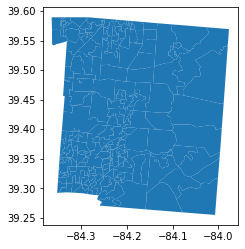

In [105]:
gp.overlay(sl_pber_splits_gdf[sl_pber_splits_gdf['COUNTYNM']=="WARREN"], sl_shp[(sl_shp["DISTRICT"]=="55")|(sl_shp["DISTRICT"]=="56")], how = "intersection").plot()
#See Warren fully overlaps/contains districts 55 and 56... So, where should the SL55 votes go?

<AxesSubplot:>

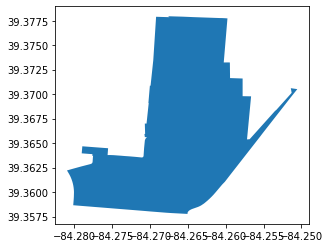

In [106]:
sl_pber_splits_gdf[sl_pber_splits_gdf['UNIQUE_ID'].str.contains("WARREN-AHB")].plot()

<AxesSubplot:>

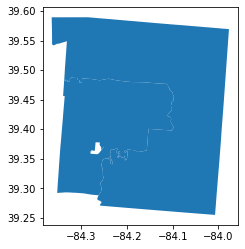

In [107]:
#Can see WARREN-AHB geom appears to be very solidly within district 56...
gp.overlay(sl_pber_splits_gdf[sl_pber_splits_gdf['UNIQUE_ID'].str.contains("WARREN-AHB")], sl_shp[(sl_shp["DISTRICT"]=="55")|(sl_shp["DISTRICT"]=="56")], how = "symmetric_difference").plot()

In [108]:
gp.overlay(sl_pber_splits_gdf[sl_pber_splits_gdf['UNIQUE_ID'].str.contains("WARREN-AHB")], sl_shp, how = "intersection")

,index,UNIQUE_ID,PRECINCT,PRECCODE,COUNTYNM,COUNTYFP,GSL001DJAR,GSL002DHUM,GSL003DMOH,GSL003RLAN,...,GSL099DZAP,GSL099RART,DIST,DIST_index,DIST_len_assignment,DIST_set,SL_DIST,ID,DISTRICT,geometry
0,8872,WARREN-AHB,AHB,AHB,WARREN,165,0.0,0.0,0.0,0.0,...,0.0,0.0,"055, 055, 055, 056, 056",8872,2,"[056, 055]","[056, 055]",15,56,"POLYGON ((-84.28038 39.36233, -84.27909 39.362..."


In [109]:
sl_elections_gdf[sl_elections_gdf["SL_DIST"]==0]

,index,UNIQUE_ID,PRECINCT,PRECCODE,COUNTYNM,COUNTYFP,GSL001DJAR,GSL002DHUM,GSL003DMOH,GSL003RLAN,...,GSL097RHOL,GSL098RKIC,GSL099DZAP,GSL099RART,geometry,DIST,DIST_index,DIST_len_assignment,DIST_set,SL_DIST
4732,4566,PORTAGE-ZZZ,ZZZ,NaN,PORTAGE,133,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-81.09907 41.16283, -81.09932 41.162...",0,4566,0,0,0
5317,5152,LORAIN-ZZZ,ZZZ,NaN,LORAIN,093,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-82.34818 41.43194, -82.34816 41.441...",0,5152,0,0,0
5354,5189,OTTAWA-ZZZ,ZZZ,NaN,OTTAWA,123,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-82.97457 41.46828, -82.97418 ...",0,5189,0,0,0
6384,6222,LUCAS-ZZZ,ZZZ,NaN,LUCAS,095,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-83.47858 41.70229, -83.47857 41.702...",0,6222,0,0,0
6400,6238,ERIE-ZZZ,ZZZ,NaN,ERIE,043,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-82.70569 41.61082, -82.70561 ...",0,6238,0,0,0
6424,6262,LAKE-ZZZ,ZZZ,NaN,LAKE,085,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-81.49518 42.09640, -81.45429 42.116...",0,6262,0,0,0
6425,6263,CUYAHOGA-ZZZ,ZZZ,NaN,CUYAHOGA,035,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-81.97058 41.87785, -81.87486 41.922...",0,6263,0,0,0
8575,8434,ASHTABULA-ZZZ,ZZZ,NaN,ASHTABULA,007,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-81.00983 42.25160, -81.00557 42.252...",0,8434,0,0,0


In [110]:
cong_elections_gdf[cong_elections_gdf["CONG_DIST"]==0]

,index,UNIQUE_ID,PRECINCT,PRECCODE,COUNTYNM,COUNTYFP,GCON01DLAN,GCON01RCHA,GCON02DMEA,GCON02RWEN,...,GCON14DKIL,GCON14RJOY,GCON15DJOS,GCON15RCAR,geometry,DIST,DIST_index,DIST_len_assignment,DIST_set,CONG_DIST
4612,4566,PORTAGE-ZZZ,ZZZ,NaN,PORTAGE,133,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-81.09907 41.16283, -81.09932 41.162...",0,4566,0,0,0
5196,5152,LORAIN-ZZZ,ZZZ,NaN,LORAIN,093,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-82.34818 41.43194, -82.34816 41.441...",0,5152,0,0,0
5233,5189,OTTAWA-ZZZ,ZZZ,NaN,OTTAWA,123,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-82.97457 41.46828, -82.97418 ...",0,5189,0,0,0
6266,6222,LUCAS-ZZZ,ZZZ,NaN,LUCAS,095,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-83.47858 41.70229, -83.47857 41.702...",0,6222,0,0,0
6282,6238,ERIE-ZZZ,ZZZ,NaN,ERIE,043,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-82.70569 41.61082, -82.70561 ...",0,6238,0,0,0
6306,6262,LAKE-ZZZ,ZZZ,NaN,LAKE,085,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-81.49518 42.09640, -81.45429 42.116...",0,6262,0,0,0
6307,6263,CUYAHOGA-ZZZ,ZZZ,NaN,CUYAHOGA,035,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-81.97058 41.87785, -81.87486 41.922...",0,6263,0,0,0
8471,8434,ASHTABULA-ZZZ,ZZZ,NaN,ASHTABULA,007,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"POLYGON ((-81.00983 42.25160, -81.00557 42.252...",0,8434,0,0,0


In [111]:
#Clean NA DIST Assignments - because CONG and SL dist all assigned, don't need cleaned, just returns same gdf
cleaned_cong_gdf = clean_na_dist_assignments(cong_elections_gdf, cong_shp, "UNIQUE_ID", "CONG_DIST", "CONG_DIST_2")
cleaned_sl_gdf = clean_na_dist_assignments(sl_elections_gdf, sl_shp, "UNIQUE_ID", "SL_DIST", "DISTRICT")
cleaned_su_gdf = clean_na_dist_assignments(su_elections_gdf, su_shp, "UNIQUE_ID", "SU_DIST", "DISTRICT")

time to run fxn:  5.882491000000016
time to run fxn:  6.445496999999989
time to run fxn:  27.23395499999998


## Check PBER with Splits

In [112]:
#Check that no null values and that UNIQUE precinct identifier is in fact unique
def check_unique_id_unique(merged_gdf):
    assert merged_gdf["UNIQUE_ID"].isna().any()==False
    assert merged_gdf["UNIQUE_ID"].nunique()==merged_gdf.shape[0]
    return "unique_id is unique"


#State, County, Precinct total vote checks adapted from pdv checks: https://github.com/nonpartisan-redistricting-datahub/pdv-resources/blob/main/pdv_functions.py
def statewide_totals_check(partner_df, partner_name, source_df, source_name, column_list):
    """Compares the totals of two election result dataframes at the statewide total level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
 
    Returns:
      difference list
    """
    print("***Statewide Totals Check***")
    diff_races=[]
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            if race not in diff_races:
                diff_races.append(race)
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\t"+ partner_name + ": "+str(partner_df[race].sum())+" votes")
            print("\t"+ source_name +": "+str(source_df[race].sum())+" votes")
        #else:
            #print(race + " is equal", "\t both dataframes " + str(partner_df[race].sum()))
    
    if (len(diff_races)==0):
        print("All contests match statewide!")
    elif (len(diff_races)>0):
        print("Contests with differences: ")
    
    return diff_races


def county_totals_check(partner_df, partner_name, source_df, source_name, column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      partner_name: String of what to call the partner in the print statement
      source_df: DataFrame of election results we are comparing to
      source_name: String of what to call the source in the print statement
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      difference list
    """
    
    print("\n***Countywide Totals Check***")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\t"+ partner_name + ": "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\t"+ source_name +": "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        #else:
            #print(race + " is equal across all counties")
            #if (full_print):
               # for val in diff[diff == 0].index.values.tolist():
                 #   county_similarities = diff[diff == 0]
                    #print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
    if (len(diff_counties)==0):
        print("All contests in all counties match!")
    elif (len(diff_counties)>0):
        print("Counties with differences: ")
        
    return diff_counties
        
    
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    """Checks a merged dataframe with two election results at the precinct level

    Args:
      merged_df: DataFrame with one set of election results joined to another
      column_list: List of races that there are votes for
      vest_on_left: Boolean specifying whether VEST data is on the left side of merged_df
      name_col: String of the column name to refer to precincts when a difference occurs
      print_level: Integer that specifies how large the vote difference in a precinct must be to be printed

    Returns:
      list of differences
    """
    print("\n***Precinct Totals Check***")
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
            
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1

    print("\nThere are ", len(merged_df.index)," total rows")
    
    if(len(diff_values)!=0):
        print(matching_rows," of these rows are the same")
        print("\nAll precincts containing differences:")
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
        print("\nThe max difference between any one shared column in a row is: ", max_diff)
        count_big_diff = len([i for i in diff_values if i > 10])
        print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    else:
        print(matching_rows," of these rows are the same")
    
    diff_list.sort()
    
    return diff_list


def run_all_checks(partner_df, partner_name, source_df, source_name, column_list,county_col,full_print=False, prec_check=True):
    check_unique_id_unique(source_df)
    #Running inner join because of expected nan value for ZZZ precincts
    merged_df = pd.merge(source_df, partner_df, on = ["UNIQUE_ID"], how = "inner", indicator=True)
    vest_on_left = False
    name_col = "UNIQUE_ID"
    #All matches statewide and county levels
    statewide_totals_check(partner_df, partner_name, source_df, source_name, column_list)
    county_totals_check(partner_df, partner_name, source_df, source_name, column_list,county_col,full_print=False)
    if prec_check ==True:
        precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0)

In [113]:
partner_df = er22.copy()
partner_df["COUNTYNM"] = partner_df["County"].str.upper()
partner_name = "original ER 22"

source_df = merge.copy()
source_name = "PBER 22"
county_col = "COUNTYNM"

print("\nchecking statewide gdf:")
run_all_checks(partner_df, partner_name, merge_st, "st gdf", list(merge_st.columns[merge_st.columns.str.startswith("G")]),county_col,full_print=False, prec_check=True)
print("\nchecking CONG w splits gdf:")
run_all_checks(partner_df, partner_name, cleaned_cong_gdf, "cong split", list(cleaned_cong_gdf.columns[cleaned_cong_gdf.columns.str.startswith("G")]),county_col,full_print=False, prec_check=False)
print("\nchecking SLDL w splits gdf:   - expect mismatch for dist 55 contests as identified above")
run_all_checks(partner_df, partner_name, cleaned_sl_gdf, "sl split", list(cleaned_sl_gdf.columns[cleaned_sl_gdf.columns.str.startswith("G")]),county_col,full_print=False, prec_check=False)
print("*****INSERT CHECK FOR SLDL gdf with no splits*****")
print("\nchecking SLDU w splits gdf")
run_all_checks(partner_df, partner_name, cleaned_su_gdf, "su split", list(cleaned_su_gdf.columns[cleaned_su_gdf.columns.str.startswith("G")]),county_col,full_print=False, prec_check=False)



checking statewide gdf:
***Statewide Totals Check***
All contests match statewide!

***Countywide Totals Check***
All contests in all counties match!

***Precinct Totals Check***

There are  8933  total rows
8933  of these rows are the same

checking CONG w splits gdf:
***Statewide Totals Check***
All contests match statewide!

***Countywide Totals Check***
All contests in all counties match!

checking SLDL w splits gdf:   - expect mismatch for dist 55 contests as identified above
***Statewide Totals Check***
GSL055DZOR has a difference of 15.0 votes
	original ER 22: 13167 votes
	sl split: 13152.0 votes
GSL055RLIP has a difference of 58.0 votes
	original ER 22: 39170 votes
	sl split: 39112.0 votes
Contests with differences: 

***Countywide Totals Check***
GSL055DZOR contains differences in these counties:
	WARREN has a difference of 15.0 votes
		original ER 22: 13167 votes
		sl split: 13152.0 votes
GSL055RLIP contains differences in these counties:
	WARREN has a difference of 58.0 vot

## Export precinct shps

In [115]:
merge_st["VTDST22"] = merge_st["COUNTYFP"]+merge_st["PRECCODE"]
st_gdf = merge_st[['UNIQUE_ID', "VTDST22",'COUNTYFP', 'COUNTYNM', 'PRECINCT', 'PRECCODE']+sorted(merge_st.columns[merge_st.columns.str.startswith("G")])+["geometry"]]
cleaned_cong_gdf["VTDST22"] = cleaned_cong_gdf["COUNTYFP"]+cleaned_cong_gdf["PRECCODE"]
cong_gdf = cleaned_cong_gdf[['UNIQUE_ID', "VTDST22",'COUNTYFP', 'COUNTYNM', 'PRECINCT', 'PRECCODE']+sorted(cleaned_cong_gdf.columns[cleaned_cong_gdf.columns.str.startswith("G")])+["geometry"]]

cleaned_su_gdf["VTDST22"] = cleaned_su_gdf["COUNTYFP"]+cleaned_su_gdf["PRECCODE"]
su_gdf = cleaned_su_gdf[['UNIQUE_ID', "VTDST22",'COUNTYFP', 'COUNTYNM', 'PRECINCT', 'PRECCODE']+sorted(cleaned_su_gdf.columns[cleaned_su_gdf.columns.str.startswith("G")])+["geometry"]]

cleaned_sl_gdf["VTDST22"] = cleaned_sl_gdf["COUNTYFP"]+cleaned_sl_gdf["PRECCODE"]
sl_gdf = cleaned_sl_gdf[['UNIQUE_ID', "VTDST22",'COUNTYFP', 'COUNTYNM', 'PRECINCT', 'PRECCODE']+sorted(cleaned_sl_gdf.columns[cleaned_sl_gdf.columns.str.startswith("G")])+["geometry"]]

merge_sl_no_splits = merge_for_splits[['UNIQUE_ID', 'PRECINCT', 'PRECCODE', 'COUNTYNM','COUNTYFP']+list(merge_for_splits.columns[merge_for_splits.columns.str.startswith("GSL")])+['geometry']].reset_index(drop=True)
merge_sl_no_splits["VTDST22"] = merge_sl_no_splits["COUNTYFP"]+merge_sl_no_splits["PRECCODE"]
sl_no_splits_gdf = merge_sl_no_splits[['UNIQUE_ID', "VTDST22",'COUNTYFP', 'COUNTYNM', 'PRECINCT', 'PRECCODE']+sorted(merge_sl_no_splits.columns[merge_sl_no_splits.columns.str.startswith("G")])+["geometry"]]

In [116]:
#Isolate elections without districts/split precincts
#WILL NEED TO RE-RUN FOR LORAIN
merge_st.to_file("./oh_2022_gen_prec_shp/oh_2022_gen_prec_st.shp")
cong_gdf.to_file("./oh_2022_gen_prec_shp/oh_2022_gen_prec_cong.shp")
su_gdf.to_file("./oh_2022_gen_prec_shp/oh_2022_gen_prec_sldu.shp")
sl_gdf.to_file("./oh_2022_gen_prec_shp/oh_2022_gen_prec_sldl.shp")
sl_no_splits_gdf.to_file("./oh_2022_gen_prec_shp/oh_2022_gen_prec_sldl_no_splits.shp")

## Create BAF

In [121]:
maup.assign(oh_blocks.to_crs(3857), merge_st.to_crs(3857))

TopologyException: side location conflict at -9149043.8625458628 5082088.7979417117 0


AttributeError: 'PreparedGeometry' object has no attribute 'is_valid'

In [122]:
oh_blocks

,GEOID20,P0010001,geometry,block_area
0,390610265001012,0,"POLYGON ((-9408772.008 4736638.463, -9408716.2...",18193.521290
1,390610047031026,166,"POLYGON ((-9398925.800 4737226.496, -9398864.7...",285719.769478
2,390610221025008,64,"POLYGON ((-9409047.747 4753834.065, -9408964.2...",43933.181434
3,390610221023005,38,"POLYGON ((-9408369.143 4753091.606, -9408338.8...",36180.346598
4,390610226022005,33,"POLYGON ((-9403127.442 4754643.691, -9403111.9...",35416.371283
...,...,...,...,...
276423,390319618003025,37,"POLYGON ((-9100461.101 4905324.000, -9100459.6...",25092.970453
276424,390319610003027,8,"POLYGON ((-9128643.078 4915238.146, -9128592.2...",4451.684701
276425,390319618001015,28,"POLYGON ((-9088987.736 4904868.083, -9088972.0...",95699.907148
276426,390319613003078,0,"POLYGON ((-9116377.896 4909960.961, -9116350.5...",133326.851072


In [126]:
prec_for_baf = merge_st[["VTDST22", "geometry"]].to_crs(3857)
blocks_for_baf = oh_blocks.to_crs(3857)
baf_overlay = gp.overlay(prec_for_baf, blocks_for_baf, how="union")

In [128]:
baf_overlay["VTDST22"][baf_overlay["GEOID20"].isna()]

358750    023ADF
358751    023ADG
358752    023ADH
358753    023ADI
358754    023ADJ
           ...  
362841    001AAP
362842    009AAZ
362843    009ABB
362844    009AAX
362845    009ACS
Name: VTDST22, Length: 4096, dtype: object

In [145]:
prec_w_assign_for_baf = oh_gen[(~oh_gen["geometry"].isna())&(oh_gen["COUNTYNM"]!="WOOD")]
                               
baf_overlay_intersect_w_updated_prec = gp.overlay(blocks_for_baf,prec_for_baf, how="intersection")

In [146]:
baf_overlay_intersect_w_updated_prec

,GEOID20,P0010001,block_area,VTDST22,geometry
0,390610265001012,0,1.819352e+04,061AFA,"POLYGON ((-9408597.460 4736672.175, -9408587.6..."
1,390610007002037,0,5.490974e+03,061AFA,"POLYGON ((-9408085.724 4736641.476, -9408072.9..."
2,390610007003039,0,9.038266e+03,061AFA,"POLYGON ((-9408069.582 4736339.224, -9407976.8..."
3,390610007003047,41,5.027291e+03,061AFA,"POLYGON ((-9408259.271 4736353.999, -9408170.3..."
4,390610007003046,0,3.207640e+03,061AFA,"POLYGON ((-9408267.509 4736348.979, -9408259.2..."
...,...,...,...,...,...
358745,390351776083007,92,5.202219e+04,035CLH,"POLYGON ((-9096093.815 5069059.955, -9096112.1..."
358746,390351776083006,62,4.135737e+04,035CLH,"POLYGON ((-9096736.112 5068974.767, -9096727.0..."
358747,390351776083002,575,1.397869e+06,035CLH,"MULTIPOLYGON (((-9096446.809 5068822.869, -909..."
358748,390351776083000,342,4.112792e+05,035CLH,"POLYGON ((-9097410.821 5069225.384, -9096909.4..."


In [151]:
baf_overlay_intersect_w_updated_prec["block_area"] = baf_overlay_intersect_w_updated_prec.area

In [154]:
baf_overlay_intersect_w_updated_prec[baf_overlay_intersect_w_updated_prec["block_area"]>.1]

,GEOID20,P0010001,block_area,VTDST22,geometry
1,390610007002037,0,5490.973891,061AFA,"POLYGON ((-9408085.724 4736641.476, -9408072.9..."
2,390610007003039,0,9038.266375,061AFA,"POLYGON ((-9408069.582 4736339.224, -9407976.8..."
3,390610007003047,41,5027.291364,061AFA,"POLYGON ((-9408259.271 4736353.999, -9408170.3..."
4,390610007003046,0,3207.639648,061AFA,"POLYGON ((-9408267.509 4736348.979, -9408259.2..."
5,390610265003008,0,32936.963742,061AFA,"POLYGON ((-9408123.016 4736143.131, -9408116.4..."
...,...,...,...,...,...
358745,390351776083007,92,52022.188934,035CLH,"POLYGON ((-9096093.815 5069059.955, -9096112.1..."
358746,390351776083006,62,41342.418431,035CLH,"POLYGON ((-9096736.112 5068974.767, -9096727.0..."
358747,390351776083002,575,1294.751433,035CLH,"MULTIPOLYGON (((-9096446.809 5068822.869, -909..."
358748,390351776083000,342,410478.856102,035CLH,"POLYGON ((-9097410.821 5069225.384, -9096909.4..."


In [162]:
b = baf_overlay_intersect_w_updated_prec.copy()
series = b["GEOID20"].value_counts()[b["GEOID20"].value_counts()>1]

In [163]:
split_blocks = list(series[series>=2].index)

In [168]:
gpby_geoid = b[b["GEOID20"].isin(split_blocks)].groupby(["GEOID20"]).sum().reset_index()

In [171]:
b_add_gpby = pd.merge(b, gpby_geoid, on = "GEOID20", how = "outer", indicator=True)

b_add_gpby["block_area_tot"] = b_add_gpby["block_area_y"]


In [177]:
b_add_gpby["area_proportion"] = b_add_gpby["block_area_x"]/b_add_gpby["block_area_tot"]

In [178]:
b_add_gpby[(b_add_gpby["area_proportion"]>0.5)&(b_add_gpby["area_proportion"]<1)]

,GEOID20,P0010001_x,block_area_x,VTDST22,geometry,P0010001_y,block_area_y,_merge,block_area_tot,area_proportion
1,390610265001012,0,18193.519922,061AKJ,"POLYGON ((-9408716.237 4736647.644, -9408597.4...",0.0,18193.521290,both,18193.521290,1.000000
7,390610007002004,0,20085.213344,061AFA,"POLYGON ((-9408454.303 4736898.691, -9408453.6...",0.0,20085.217314,both,20085.217314,1.000000
10,390610265003023,100,12669.096925,061AFB,"POLYGON ((-9408074.258 4735893.968, -9408252.4...",200.0,12669.113186,both,12669.113186,0.999999
11,390610007003036,178,17391.512480,061AFA,"POLYGON ((-9407750.096 4736401.051, -9407717.8...",356.0,17391.512511,both,17391.512511,1.000000
13,390610007002003,0,3275.473325,061AFA,"POLYGON ((-9408417.233 4736971.567, -9408406.2...",0.0,3275.473354,both,3275.473354,1.000000
...,...,...,...,...,...,...,...,...,...,...
358634,390351164001000,70,43735.325057,035ARX,"POLYGON ((-9085473.157 5090952.930, -9085400.6...",210.0,43737.816980,both,43737.816980,0.999943
358636,390351164002008,33,9038.532845,035ARX,"POLYGON ((-9085401.133 5091077.694, -9085401.4...",66.0,9041.175124,both,9041.175124,0.999708
358637,390351182003001,68,36320.023472,035ASH,"POLYGON ((-9085399.322 5090631.279, -9085399.5...",136.0,36320.518751,both,36320.518751,0.999986
358640,390351164001005,163,65919.634475,035ASW,"POLYGON ((-9085400.354 5090728.242, -9085399.5...",326.0,65919.873309,both,65919.873309,0.999996


In [157]:
#os.mkdir("./oh_gen_2022_prec_baf_DRAFT2/")
baf_overlay_intersect_w_updated_prec.to_file("./oh_gen_2022_prec_baf_DRAFT2/oh_gen_2022_prec_baf_DRAFT2.shp")

In [131]:
baf_overlay_intersect = gp.overlay(blocks_for_baf,prec_for_baf, how="intersection")
baf_overlay_intersect

,GEOID20,P0010001,block_area,VTDST22,geometry
0,390610265001012,0,1.819352e+04,061AFA,"POLYGON ((-9408597.460 4736672.175, -9408587.6..."
1,390610007002037,0,5.490974e+03,061AFA,"POLYGON ((-9408085.724 4736641.476, -9408072.9..."
2,390610007003039,0,9.038266e+03,061AFA,"POLYGON ((-9408069.582 4736339.224, -9407976.8..."
3,390610007003047,41,5.027291e+03,061AFA,"POLYGON ((-9408259.271 4736353.999, -9408170.3..."
4,390610007003046,0,3.207640e+03,061AFA,"POLYGON ((-9408267.509 4736348.979, -9408259.2..."
...,...,...,...,...,...
358745,390351776083007,92,5.202219e+04,035CLH,"POLYGON ((-9096093.815 5069059.955, -9096112.1..."
358746,390351776083006,62,4.135737e+04,035CLH,"POLYGON ((-9096736.112 5068974.767, -9096727.0..."
358747,390351776083002,575,1.397869e+06,035CLH,"MULTIPOLYGON (((-9096446.809 5068822.869, -909..."
358748,390351776083000,342,4.112792e+05,035CLH,"POLYGON ((-9097410.821 5069225.384, -9096909.4..."


In [137]:
baf_overlay_intersect["VTDST22"][baf_overlay_intersect["GEOID20"].isna()]

Series([], Name: VTDST22, dtype: object)

In [134]:
set(baf_overlay_intersect["GEOID20"])

{'391034030011004',
 '391079673004049',
 '390351181012025',
 '390351027003032',
 '390319612003078',
 '390490007301012',
 '391590501002004',
 '391559311002005',
 '390599774003033',
 '390679759003047',
 '390351712042009',
 '391199114001045',
 '391690020002024',
 '390479264001053',
 '390030109003032',
 '390830075003012',
 '390130110002125',
 '390070006032034',
 '391517007012013',
 '390351214012012',
 '391130010002008',
 '390351968001019',
 '390610086012010',
 '390998130002043',
 '390572403024021',
 '391559335002010',
 '390490088221014',
 '391439621004009',
 '390630007003003',
 '390159519002004',
 '391159691003026',
 '390279643003025',
 '390351027002016',
 '390490078122009',
 '391730225002018',
 '391390030012066',
 '390070010011024',
 '391230510005031',
 '391517115024016',
 '391690017004018',
 '391499723002024',
 '390930805003004',
 '390351712032004',
 '391590506021017',
 '391390008001012',
 '390017701003046',
 '390610102014001',
 '390690007004032',
 '391670217004021',
 '390070014021035',


In [132]:
len(set(baf_overlay_intersect["GEOID20"])-set(oh_blocks["GEOID20"]))

0

In [135]:
len(set(oh_blocks["GEOID20"])-set(baf_overlay_intersect["GEOID20"]))

209

In [138]:
ph_baf = pd.read_csv("../../../Downloads/oh_gen_2022_prec_baf.csv")

In [140]:
ph_baf

,GEOID20,PRECINCT
0,390017701003018,ADAMS-AAN
1,390017701003043,ADAMS-AAP
2,390017701003049,ADAMS-AAP
3,390017701003050,ADAMS-AAN
4,390017702002026,ADAMS-ABG
...,...,...
276423,390950097003005,NO ASSIGNMENT
276424,390950087014007,NO ASSIGNMENT
276425,390950011001006,NO ASSIGNMENT
276426,390950083022018,NO ASSIGNMENT


In [139]:
len(set(ph_baf["GEOID20"])-set(baf_overlay_intersect["GEOID20"]))

276428

In [141]:
len(set(baf_overlay_intersect["GEOID20"])-set(ph_baf["GEOID20"]))

276219

In [118]:
#Function to adjust Census VAP to account for incarcerated pop by subtracting and then assign 0 to any negative values
def modify_P0040001_P0050003(block_gdf):
    block_gdf['P0040001-P0050003'] = block_gdf['P0040001'] - block_gdf['P0050003']
    print("Error raised iff the number of incarcerated blocks with non-zero population does NOT equal the number of modified vap blocks.")
    assert (len(block_gdf[block_gdf['P0050003']!=0]) - len(block_gdf[block_gdf['P0040001']!=block_gdf['P0040001-P0050003']])) == 0
    block_gdf.loc[block_gdf['P0040001-P0050003']<0, 'P0040001-P0050003'] = 0

    return block_gdf


#Functions for running maup
def check_valid_rows(block_gdf, precinct_gdf):
    prec_geom = precinct_gdf.geometry
    valid_rows = precinct_gdf[~(prec_geom.isna() | prec_geom.is_empty)]
    print('valid precinct rows: ', valid_rows.shape)

    block_geom = block_gdf.geometry
    block_valid_rows = block_gdf[~(block_geom.isna() | block_geom.is_empty)]
    print('valid block rows: ', block_valid_rows.shape)
    

def fix_buffer(gdf):
    """
    return (GeoDataFrame) with the 'bufer(0) trick' applied
    :gdf: (GeoDataFrame) object
    Can be useful when trying to mitigate 'self-intersection' issues
    """
    buffered = gdf.buffer(0)
    gdf.drop(columns=["geometry"])
    # gdf['geometry'] = gdf.apply(lambda x: x.geometry.buffer(0), axis=1)
    gdf["geometry"] = buffered
    return gdf


def maup_assignment_series(block_gdf, precinct_gdf):
    block_gdf = block_gdf.to_crs(precinct_gdf.crs)
    print('block_gdf shape: ', block_gdf.shape, '\n precinct_gdf shape: ', precinct_gdf.shape)

    block_gdf["maup_assignment"] = maup.assign(
        fix_buffer(block_gdf), fix_buffer(precinct_gdf)
    )
    print(block_gdf[block_gdf['maup_assignment'].isna()].shape[0], " null assignments in maup series")
    return block_gdf


def maup_pre_vote_setup(block_gdf, precinct_gdf, PRECID_block):
    block_gdf = block_gdf.to_crs(precinct_gdf.crs)
    bgdf = maup_assignment_series(block_gdf, precinct_gdf)
    assert bgdf['maup_assignment'].isna().any() == False
    bgdf[PRECID_block] = bgdf['maup_assignment'].map(lambda idx: str(precinct_gdf.loc[idx]["UNIQUE_ID"]))
    
    return bgdf

    
def maup_assign_labels(block_gdf, precinct_gdf, precinctid_input, distid_input):
    #Assign precinct IDs to block file using assign series
    block_gdf[precinctid_input] = block_gdf["maup_assignment"].map(
        lambda idx: str(precinct_gdf.loc[idx]["UNIQUE_ID"])
    )
    if "CONG_DIST" in precinct_gdf.columns:
        block_gdf[distid_input] = block_gdf["maup_assignment"].map(
            lambda idx: str(precinct_gdf.loc[idx]["CONG_DIST"])
        )
    if "SLDL_DIST" in precinct_gdf.columns:
        block_gdf[distid_input] = block_gdf["maup_assignment"].map(
            lambda idx: str(precinct_gdf.loc[idx]["SLDL_DIST"])
        )
    if "SLDU_DIST" in precinct_gdf.columns:
        block_gdf[distid_input] = block_gdf["maup_assignment"].map(
            lambda idx: str(precinct_gdf.loc[idx]["SLDU_DIST"])
        )
    print("Label assignment complete")

    return block_gdf


def election_cols(gdf):
    election_cols = list(gdf.columns[gdf.columns.str.startswith('G')])
    return election_cols 


def assign_votes(variables, election_columns, precinct_gdf, block_gdf):
    precinct_gdf[variables] = block_gdf[variables].groupby(block_gdf["maup_assignment"]).sum()
    print(variables, ' added to precinct_gdf based on maup assignment')
    bl_to_prec_weights = block_gdf[variables] / block_gdf["maup_assignment"].map(precinct_gdf[variables])
    block_votes = block_gdf.copy(deep=True)
    block_votes[election_columns] = maup.prorate(
        block_gdf["maup_assignment"], precinct_gdf[election_columns], bl_to_prec_weights
    )
    return block_votes


def run_maup(block_gdf, precinct_gdf, precinctid_input, pop_variable):
    #Assign identifiers
    block_gdf = maup_assignment_series(block_gdf, precinct_gdf)
    block_gdf = maup_assign_labels(block_gdf, precinct_gdf, precinctid_input)

    #Assign votes
    election_columns = election_cols(precinct_gdf)
    block_votes = assign_votes(pop_variable, election_columns, precinct_gdf, block_gdf)
    
    return block_votes   


def column_total_check(election_columns, block_gdf, precinct_gdf):
    for val in election_columns:
        vote_dif = block_gdf[val].sum()-precinct_gdf[val].sum()
        if (abs(vote_dif) <=1e-1):
            #print(val+": EQUAL", ' - total: ', 'block:', str(block_gdf[val].sum()), 'prec:', str(precinct_gdf[val].sum()), 'diff:', block_gdf[val].sum()-precinct_gdf[val].sum())
            continue
        else:
            print(val+": DIFFERENCE OF " + str(vote_dif)+ " VOTES", ' - block total: ', str(block_gdf[val].sum()), ', precinct total: ', str(precinct_gdf[val].sum()))  
            
            
def precinct_sum_check(prec_gdf, block_gdf, blk_prec_id):
    prec_gpbyprec = prec_gdf.groupby(['UNIQUE_ID']).sum()
    blk_gpbyprec = block_gdf.groupby([blk_prec_id]).sum()
    prec_w_difs_list = []
    
    prec_gpbyprec.sort_values(by='UNIQUE_ID',inplace=True)
    prec_gpbyprec.reset_index(inplace = True)
    blk_gpbyprec.sort_values(by= blk_prec_id, inplace=True)
    blk_gpbyprec.reset_index(inplace = True)
    
    for i in range(0, prec_gdf['UNIQUE_ID'].nunique()):
        for col in election_cols(prec_gdf):
            prec_diff = round(blk_gpbyprec[col].iloc[i], 1) - round(prec_gpbyprec[col].iloc[i], 1)
            if (prec_diff!=0):
                prec_w_difs_list.append(prec_gpbyprec.index[i])
                print("prec id: ", blk_gpbyprec.index[i], prec_gpbyprec.index[i], col, "block: ", round(blk_gpbyprec[col].iloc[i],1), 
                      "prec: ", round(prec_gpbyprec[col].iloc[i],1), "diff: ", prec_diff)
    print("precs to check: ", set(prec_w_difs_list))
    print("Precinct check complete!")
            

In [ ]:
maup.assign(oh_blocks[(oh_blocks["GEOID20"].isin(requires_additional_checking))|(oh_blocks["GEOID20"].isin(can_fix_w_automation))], oh_gen[(~oh_gen["geometry"].isna())&(oh_gen["COUNTYNM"]!="WOOD")].to_crs(3857))

In [ ]:
maup_pre_vote_setup(oh_bloc, prec, "PREC")

In [63]:
oh_gen.to_file("./oh_2022_gen_prec_shp_wip/FOR_BAF.shp")

In [ ]:
bprec = maup_pre_vote_setup(census_block_gdf, prec_remove_prob_counties, "PREC")

In [64]:
oh_gen

,UNIQUE_ID,COUNTYFP,COUNTYNM,PRECINCT,PRECCODE,G22ATGDCRO,G22ATGRYOS,G22AUDDSAP,G22AUDRFAB,G22CJUDBRU,...,GSU25DDEM,GSU25RWYS,GSU27DGOE,GSU27RROE,GSU29RSCH,GSU31RLAN,GSU33DHAG,GSU33RRUL,geometry,precinct_area
0,CLARK-PRECINCT BETH 1,023,CLARK,PRECINCT BETH 1,ADF,158.0,554.0,168.0,551.0,191.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-9350172.427 4849721.416, -9350104.6...",2.443598e+07
1,CLARK-PRECINCT BETH 2,023,CLARK,PRECINCT BETH 2,ADG,140.0,445.0,148.0,443.0,151.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-9353559.322 4849091.352, -9353537.0...",2.011734e+06
2,CLARK-PRECINCT BETH 3,023,CLARK,PRECINCT BETH 3,ADH,143.0,458.0,158.0,449.0,167.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((-9355019.500 4849732.006, -935...",3.714236e+06
3,CLARK-PRECINCT BETH 4,023,CLARK,PRECINCT BETH 4,ADI,162.0,674.0,172.0,659.0,191.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-9355443.293 4856857.133, -9355450.9...",3.969481e+07
4,CLARK-PRECINCT BETH 5,023,CLARK,PRECINCT BETH 5,ADJ,201.0,527.0,207.0,517.0,220.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-9347394.560 4855911.883, -9347193.0...",4.794883e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8936,CUYAHOGA-INDEPENDENCE-00-D,035,CUYAHOGA,INDEPENDENCE,BVF,224.0,429.0,220.0,407.0,247.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-9086961.887 5070592.732, -9086961.8...",1.373910e+07
8937,BUTLER-LIBERTY TWP 1,017,BUTLER,LIBERTY TWP 1,AGL,127.0,286.0,133.0,280.0,144.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-9403867.727 4783363.064, -9403746.5...",4.737905e+06
8938,CUYAHOGA-MIDDLEBURG HEIGHTS-01-B,035,CUYAHOGA,MIDDLEBURG HEIGHTS,CCI,133.0,150.0,132.0,151.0,147.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-9112021.536 5064751.206, -9111766.4...",8.810695e+06
8939,CUYAHOGA-MIDDLEBURG HEIGHTS-01-B,035,CUYAHOGA,MIDDLEBURG HEIGHTS,CCI,133.0,150.0,132.0,151.0,147.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-9112021.536 5064751.206, -9111766.4...",8.810695e+06
